In [1]:
# #conda install -c conda-forge feature_engine
!pip install feature_engine
!pip install category_encoders
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 13.1 MB/s eta 0:00:00


In [2]:
## Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import optuna

### Loading Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

#Importing the data
df= pd.read_excel("/content/drive/My Drive/Retail Data.xlsx")
df.head(5)
#path= "C:\\Users\\RodahNambuyaChepkori\\Documents\\Skillup\\PROJECT 101\\Retail Data.xlsx" #C:\\Users\\RodahNambuyaChepkori\\Documents\\Skillup\\"
#df = pd.read_excel(path)

Mounted at /content/drive


STOREID    STORE_NAME   County   Region DEPARTMENT           CATEGORY  \
0      C2    Two Rivers  Nairobi  Nairobi    Cereals  Breakfast Cereals   
1      C2       The Hub  Nairobi  Nairobi    Cereals  Breakfast Cereals   
2      C2  Business Bay  Nairobi  Nairobi    Cereals  Breakfast Cereals   
3      C2   South Field  Nairobi  Nairobi    Cereals  Breakfast Cereals   
4      C2           Trm  Nairobi  Nairobi    Cereals  Breakfast Cereals   

  SUB_CATEGORY ITEM_CODE                             ITEM_NAME  \
0   Cornflakes      39596  M/HARVEST CEREAL CORNFLAKES VPA500G   
1   Cornflakes      39596  M/HARVEST CEREAL CORNFLAKES VPA500G   
2   Cornflakes      39596  M/HARVEST CEREAL CORNFLAKES VPA500G   
3   Cornflakes      39596  M/HARVEST CEREAL CORNFLAKES VPA500G   
4   Cornflakes      39596  M/HARVEST CEREAL CORNFLAKES VPA500G   

             BRAND  ...       RRP  SUPPLIER_ID  \
0  Morning Harvest  ...  313.4203           11   
1  Morning Harvest  ...  313.4203           11   
2  Morning Harvest  ...  313.4203           11   
3  Morning Harvest  ...  313.4203           11   
4  Morning Harvest  ...  313.4203           11   

                         SUPPLIER      Month Inflation    CPI  GDP  Holiday  \
0  Healthy U Two Thousand Limited 2024-04-01         5  138.4  5.4        2   
1  Healthy U Two Thousand Limited 2024-04-01         5  138.4  5.4        2   
2  Healthy U Two Thousand Limited 2024-04-01         5  138.4  5.4        2   
3  Healthy U Two Thousand Limited 2024-04-01         5  138.4  5.4        2   
4  Healthy U Two Thousand Limited 2024-04-01         5  138.4  5.4        2   

   Promotion_Length  Number _of_Active_Promotion  
0                13                            2  
1                13                            2  
2                13                            2  
3                13                            2  
4                13                            2  

[5 rows x 22 columns]

In [ ]:
df= pd.read_excel("/content/drive/My Drive/Retail Data.xlsx")
df.head(5)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/Retail Data.xlsx'

#### Data Proflling

In [ ]:
#data features
df.shape

(1025946, 22)

In [ ]:
# getting an overview of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025946 entries, 0 to 1025945
Data columns (total 22 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   STOREID                      1025946 non-null  object        
 1   STORE_NAME                   1025946 non-null  object        
 2   County                       1025946 non-null  object        
 3   Region                       1025946 non-null  object        
 4   DEPARTMENT                   1025946 non-null  object        
 5   CATEGORY                     1025946 non-null  object        
 6   SUB_CATEGORY                 1025946 non-null  object        
 7   ITEM_CODE                    1025946 non-null  object        
 8   ITEM_NAME                    1024482 non-null  object        
 9   BRAND                        1025946 non-null  object        
 10  QUANTITY                     1025946 non-null  int64         
 11  TOTAL_SALES

In [4]:
# Renaming columns
df.rename(columns={
    'QUANTITY': 'Qty',
    'TOTAL_SALES': 'Sales',
    'RRP': 'Price',
    'SUPPLIER_ID': 'Supplier_Id',
    'Number _of_Active_Promotion': 'Promotion'

}, inplace=True)

# Get object type columns
object_cols = df.select_dtypes(include='object').columns

# Capitalize the first letter of each column name
df.columns = [col.capitalize() if col in object_cols else col for col in df.columns]


# Display the updated columns to confirm
print(df.columns)

Index(['Storeid', 'Store_name', 'County', 'Region', 'Department', 'Category',
       'Sub_category', 'Item_code ', 'Item_name', 'Brand', 'Qty', 'Sales',
       'Price', 'Supplier_Id', 'Supplier', 'Month', 'Inflation', 'CPI', 'GDP',
       'Holiday', 'Promotion_Length', 'Promotion'],
      dtype='object')


# 2. Exploratory Data Analysis (EDA)

In [ ]:
## Descriptive statistics
df.describe().round(2)

Qty       Sales       Price  Supplier_Id  \
count  1025946.00  1025946.00  1025946.00   1025946.00   
mean        41.56     8173.71      314.14        82.02   
min         -5.00    -3350.00        1.81         1.00   
25%          3.00      594.83      116.38        20.00   
50%          7.00     1593.12      206.90        77.00   
75%         20.00     4437.93      369.72       112.00   
max      29256.00  4438201.88     9801.00       222.00   
std        224.00    41415.00      381.44        59.64   

                               Month   Inflation         CPI         GDP  \
count                        1025946  1025946.00  1025946.00  1025946.00   
mean   2024-01-08 03:26:17.156692480        6.21      136.77        5.39   
min              2022-07-01 00:00:00        3.00      125.10        4.80   
25%              2023-05-01 00:00:00        4.00      133.01        5.40   
50%              2023-12-01 00:00:00        7.00      137.55        5.40   
75%              2024-11-01 00:00:00        8.00      140.81        5.60   
max              2025-04-01 00:00:00        9.00      144.09        5.60   
std                              NaN        1.99        5.69        0.26   

          Holiday  Promotion_Length   Promotion  
count  1025946.00        1025946.00  1025946.00  
mean         1.10             13.74        1.45  
min          0.00             13.00        1.00  
25%          0.00             13.00        1.00  
50%          1.00             13.00        1.00  
75%          2.00             15.00        2.00  
max          3.00             16.00        3.00  
std          1.11              1.10        0.74

In [ ]:
#Checking data skewness
data_skewness = df.select_dtypes(include=np.number).skew().round(2)
data_skewness

Qty                 25.01
Sales               23.64
Price                5.71
Supplier_Id          0.45
Inflation           -0.08
CPI                 -0.57
GDP                 -1.30
Holiday              0.49
Promotion_Length     0.94
Promotion            1.27
dtype: float64

In [ ]:
## Cheking the Kurtosis of the data- describes the 'tailedness' of a distribution, indicating how heavily the tails differ from the tails of a normal distribution
data_kurtosis = df.select_dtypes(include=np.number).kurt().round(2)
data_kurtosis

Qty                 1333.90
Sales               1156.70
Price                 67.39
Supplier_Id           -0.88
Inflation             -1.33
CPI                   -0.74
GDP                    0.37
Holiday               -1.16
Promotion_Length      -0.82
Promotion              0.01
dtype: float64

### 2.1. Univariate analysis

#### Frequency Distributions of Numeric Values

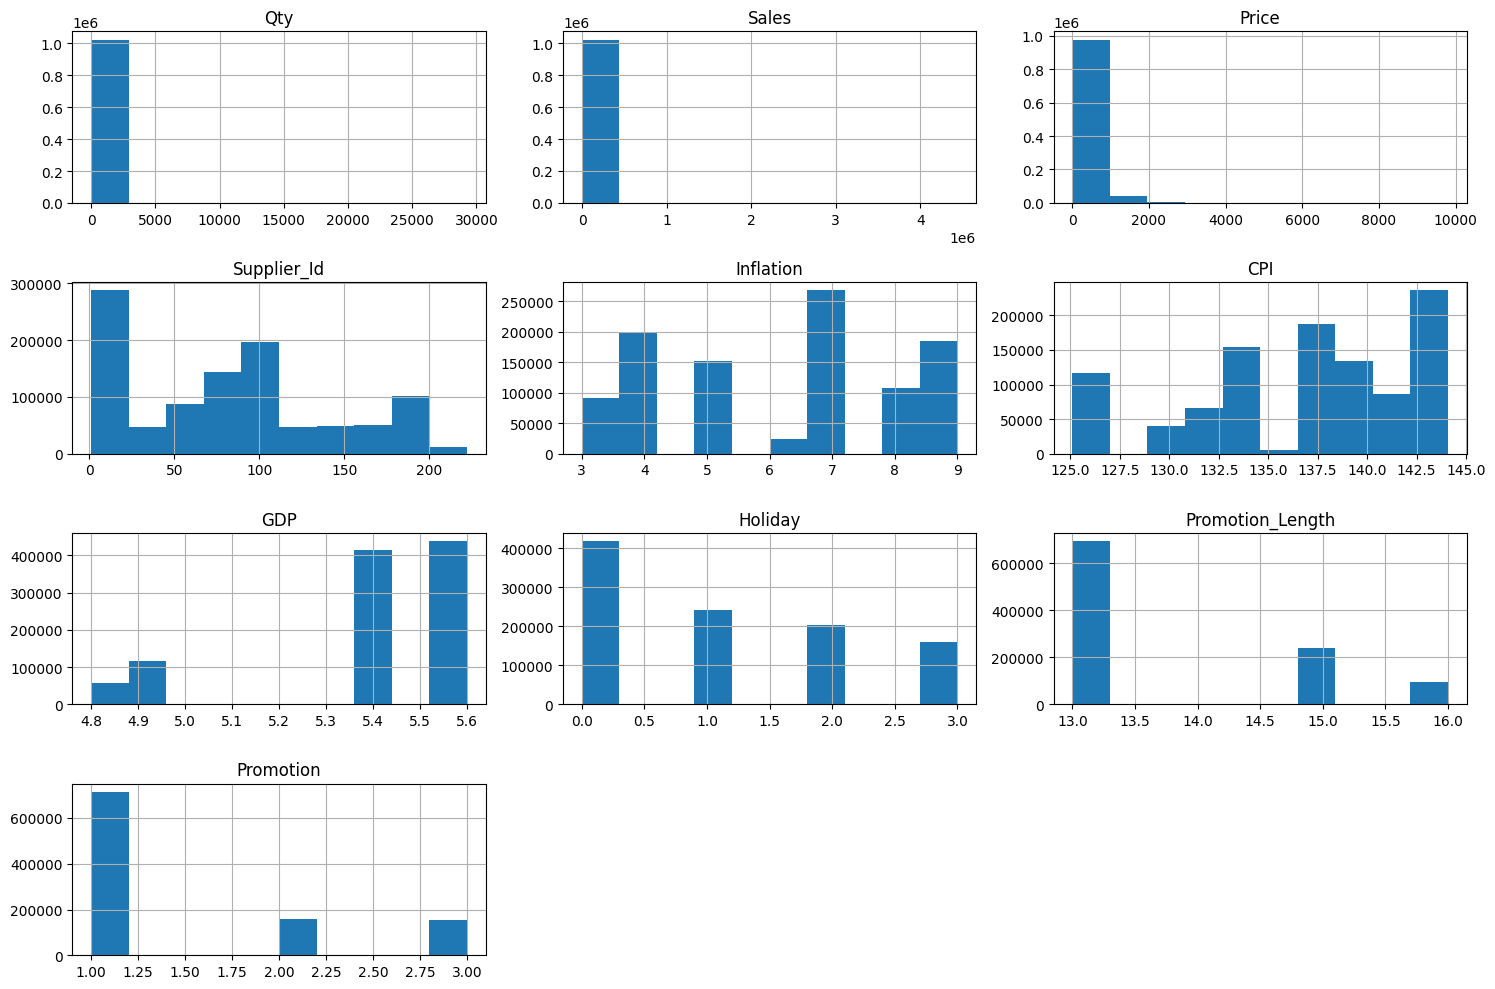

In [ ]:
#getting numeric columns
numerical_cols = df.select_dtypes(include=['number']).columns

# Create histograms for numerical columns
df[numerical_cols].hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

#### Frequency Distributions for Categorical Features

In [ ]:
# Get categorical columns
categorical_cols = df.select_dtypes(include='object').columns

# Print frequency distribution for each categorical column
for col in categorical_cols:
    print(f"Frequency distribution for {col}:")
    print(df[col].value_counts())
    print("\n" + "="*30 + "\n")

Frequency distribution for Storeid:
Storeid
QM003    884928
N001     112037
C2        28981
Name: count, dtype: int64


Frequency distribution for Store_name:
Store_name
Kilimani          21427
Kiambu Rd         21284
Chania            20605
Bandari           19846
Embakasi          19543
                  ...  
Spring Valley        89
Kenol Makutano       78
Kangemi              54
Haile Selassie       49
Tatu City             5
Name: count, Length: 184, dtype: int64


Frequency distribution for County:
County
Nairobi     580488
Kajiado      65463
Kiambu       64028
Kisumu       47973
Mombasa      41719
Machakos     41623
Mtwapa       30889
Eldoret      21951
Kisii        20215
Laikipia     17643
Nakuru       15974
Kakamega     15794
Kitale       15056
Kitui        14849
Kericho      10042
Narok         7644
Coast         3507
Malindi       2600
Kwale         1395
Embu          1347
Kilifi        1302
Western       1261
Nyeri         1139
Meru          1023
Kapsabet       570
Bungoma 

#### Box Plots for Numerical Features

Total outliers: 41436


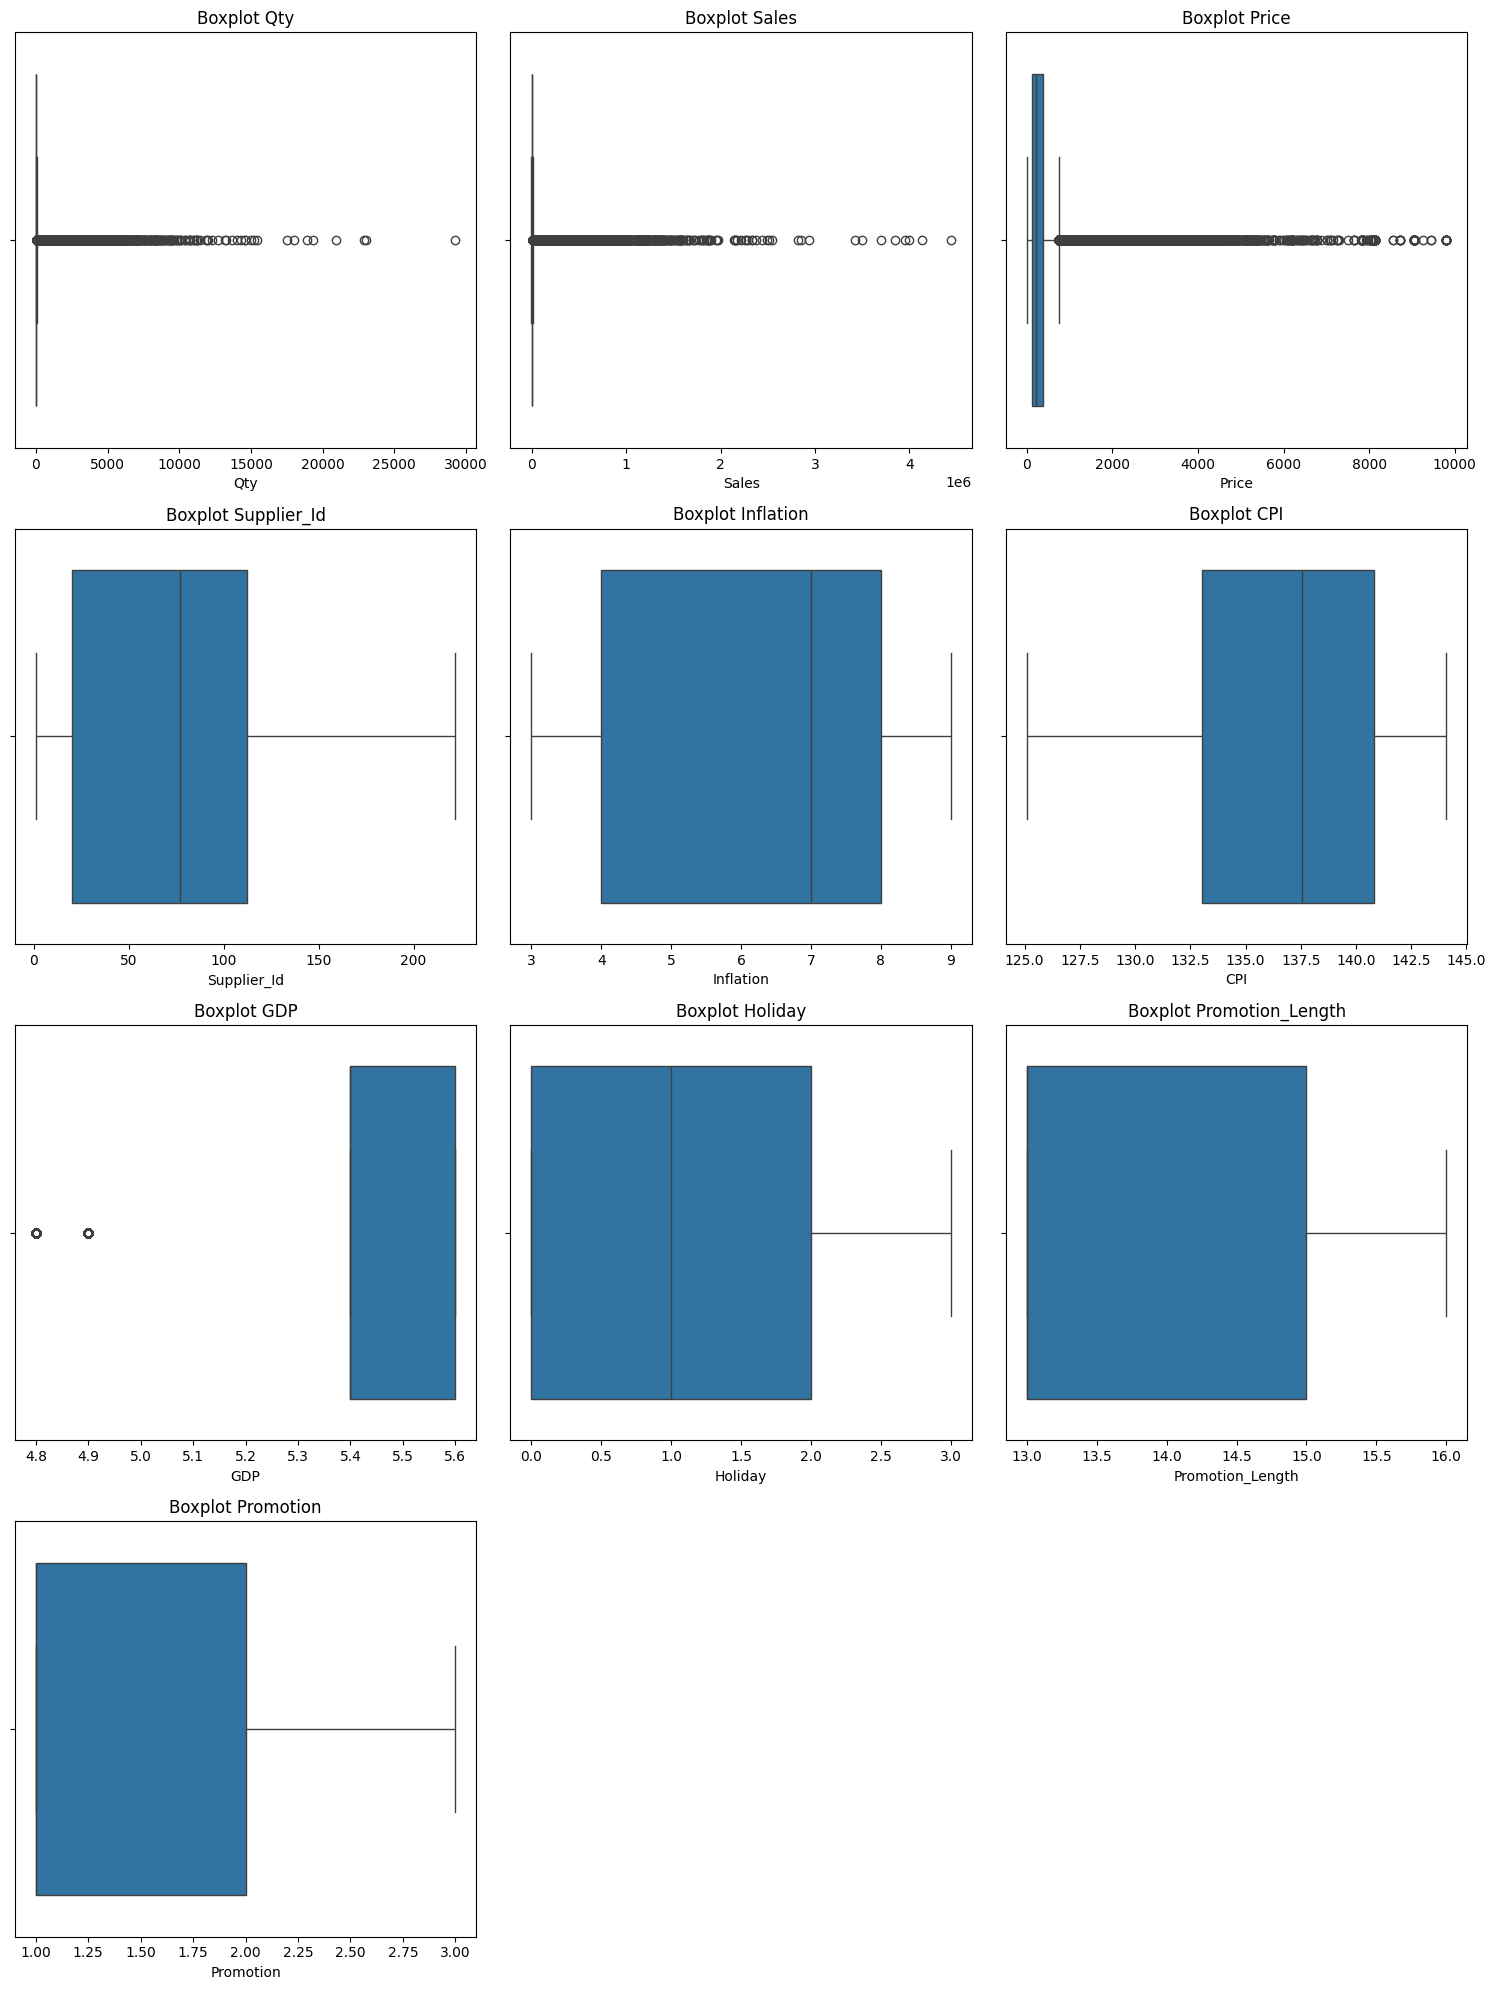

In [ ]:
# Z-score method to get the number of outliers
from scipy.stats import zscore

z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))
outliers = np.where(z_scores > 3)
print(f"Total outliers: {len(outliers[0])}")

# Boxplots for numeric features
numeric_cols = df.select_dtypes(include=np.number).columns
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Boxplot {col}")

# Hide any unused subplots
for i in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# 2.2. Multivariate Analysis

### Correlation of numeric values with the target variable

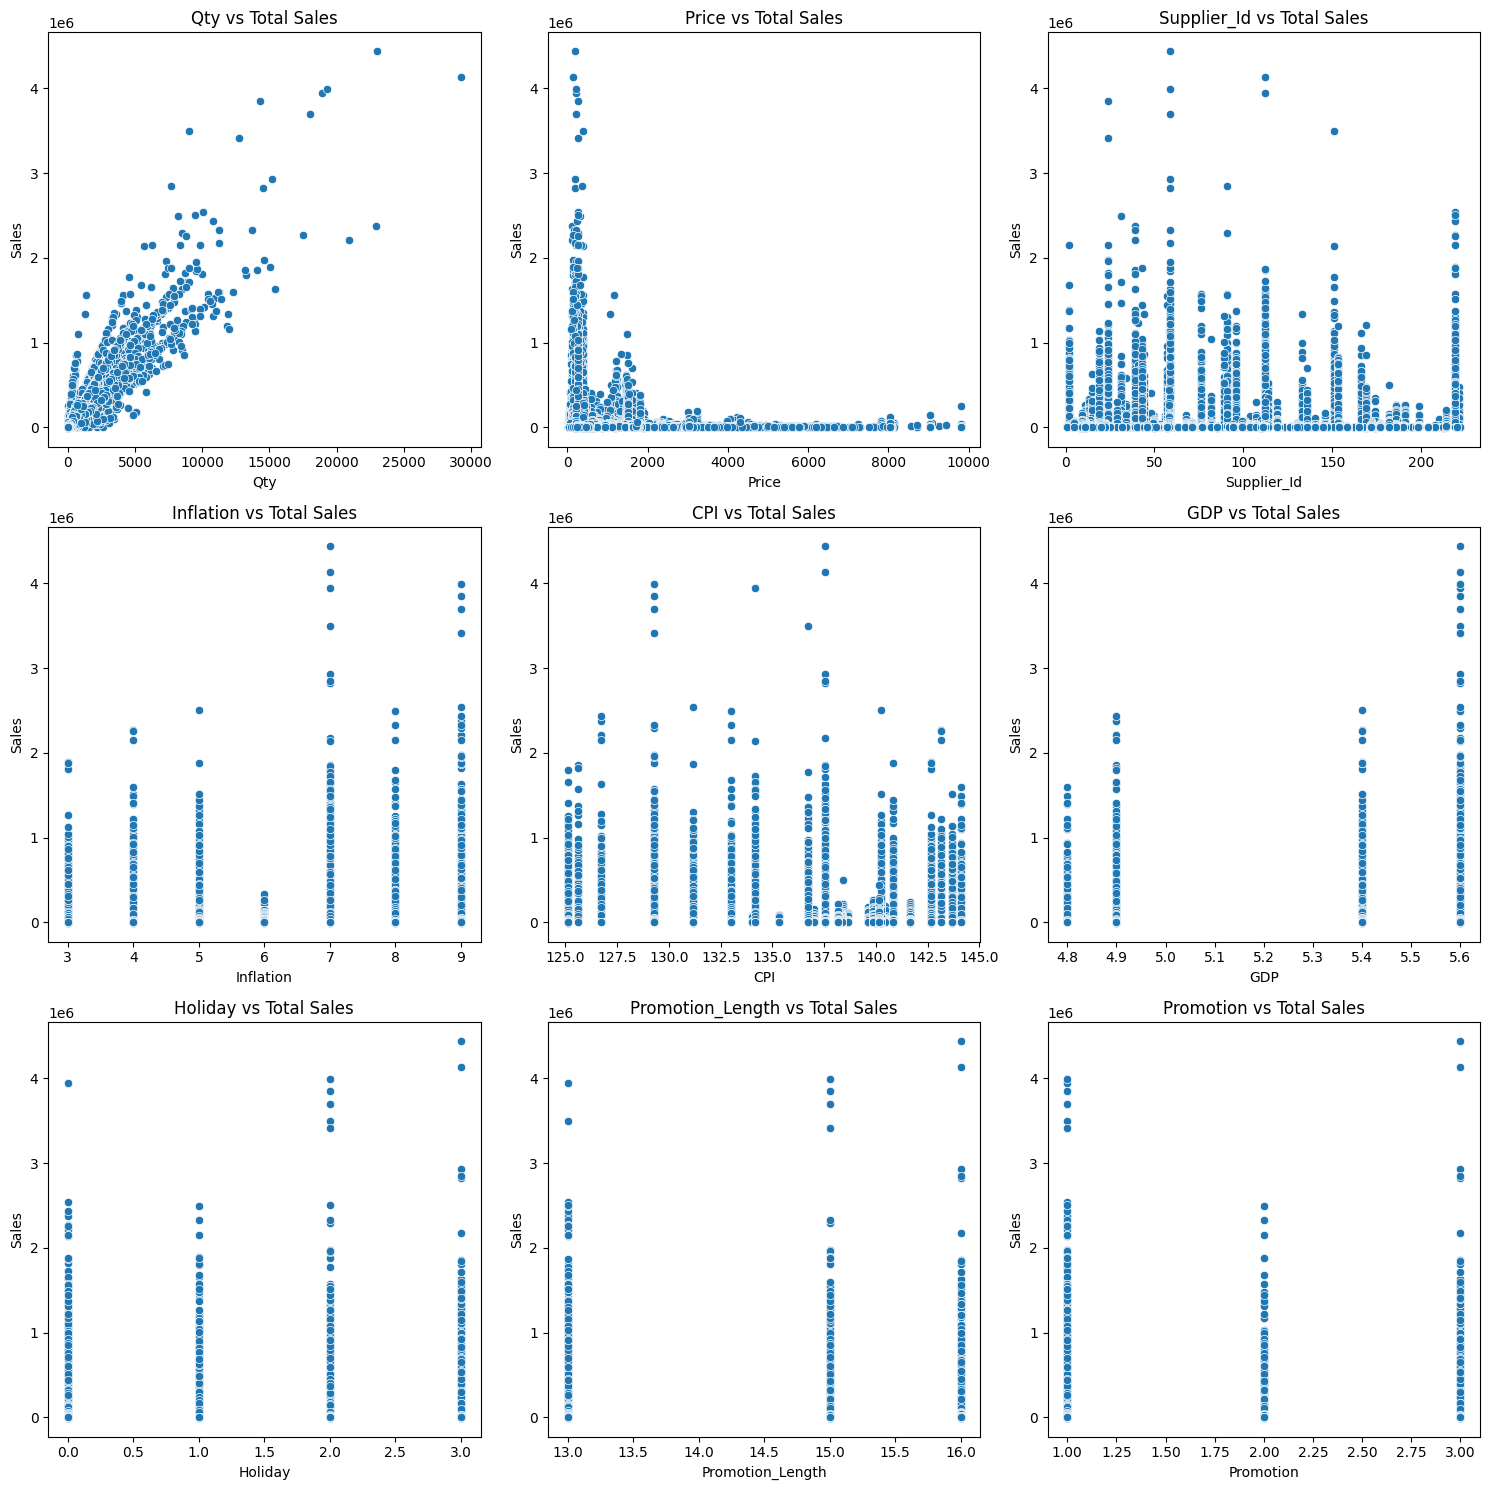

In [ ]:
numerical_cols = ['Qty', 'Price', 'Supplier_Id', 'Inflation', 'CPI', 'GDP',
       'Holiday', 'Promotion_Length', 'Promotion',]
n_cols = 3
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.scatterplot(data = df, x = col,y = 'Sales', ax=axes[i])
    axes[i].set_title(f"{col} vs Total Sales")

# Hide any unused subplots
for i in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

#### Correlation matrix

<Axes: >

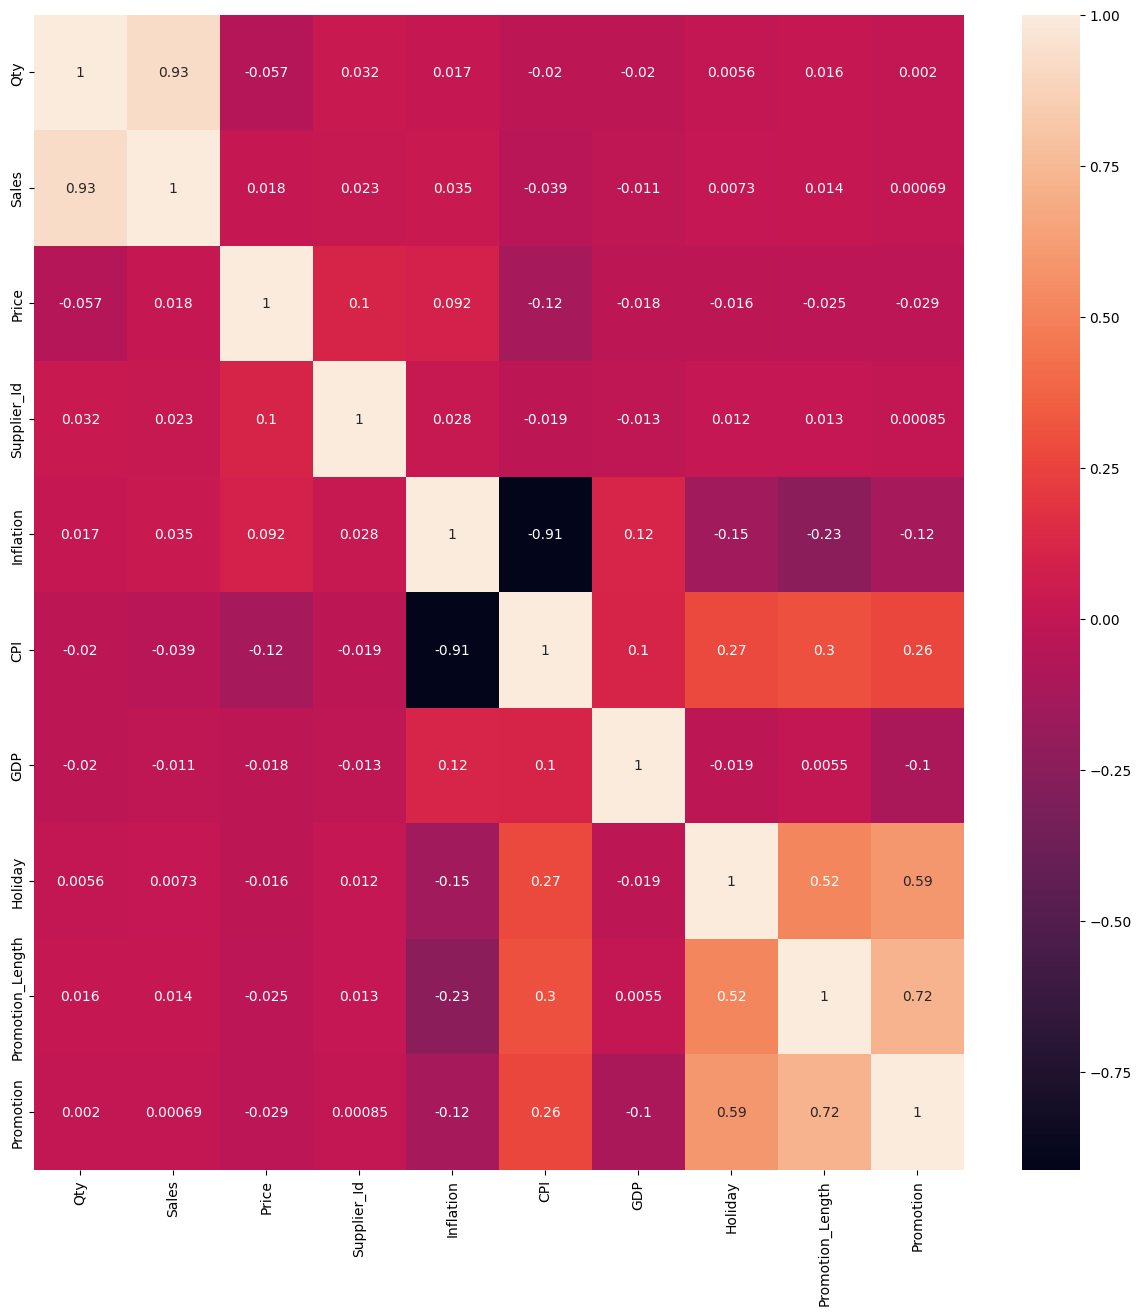

In [ ]:
##correlation heatma
s= df.select_dtypes(include ='number').corr()
plt.figure(figsize =(15,15))
sns.heatmap(s, annot= True)

#### Categorical Value Visualisation

In [ ]:
cat_cols=df.select_dtypes(include='object').columns
cat_cols

Index(['Storeid', 'Store_name', 'County', 'Region', 'Department', 'Category',
       'Sub_category', 'Item_code ', 'Item_name', 'Brand', 'Supplier'],
      dtype='object')

## Sales contributions by the retail store

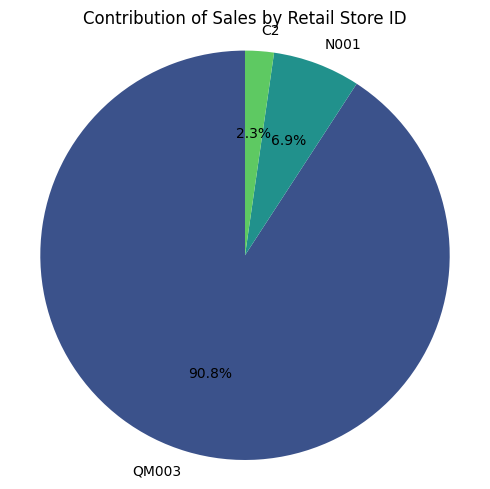

In [ ]:
# Calculate total sales by Store ID
store_sales = df.groupby('Storeid')['Sales'].sum().sort_values(ascending=False)

# Create a pie chart
plt.figure(figsize=(5, 5))
plt.pie(store_sales, labels=store_sales.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(store_sales)))
plt.title('Contribution of Sales by Retail Store ID')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

## Regional sales distribution

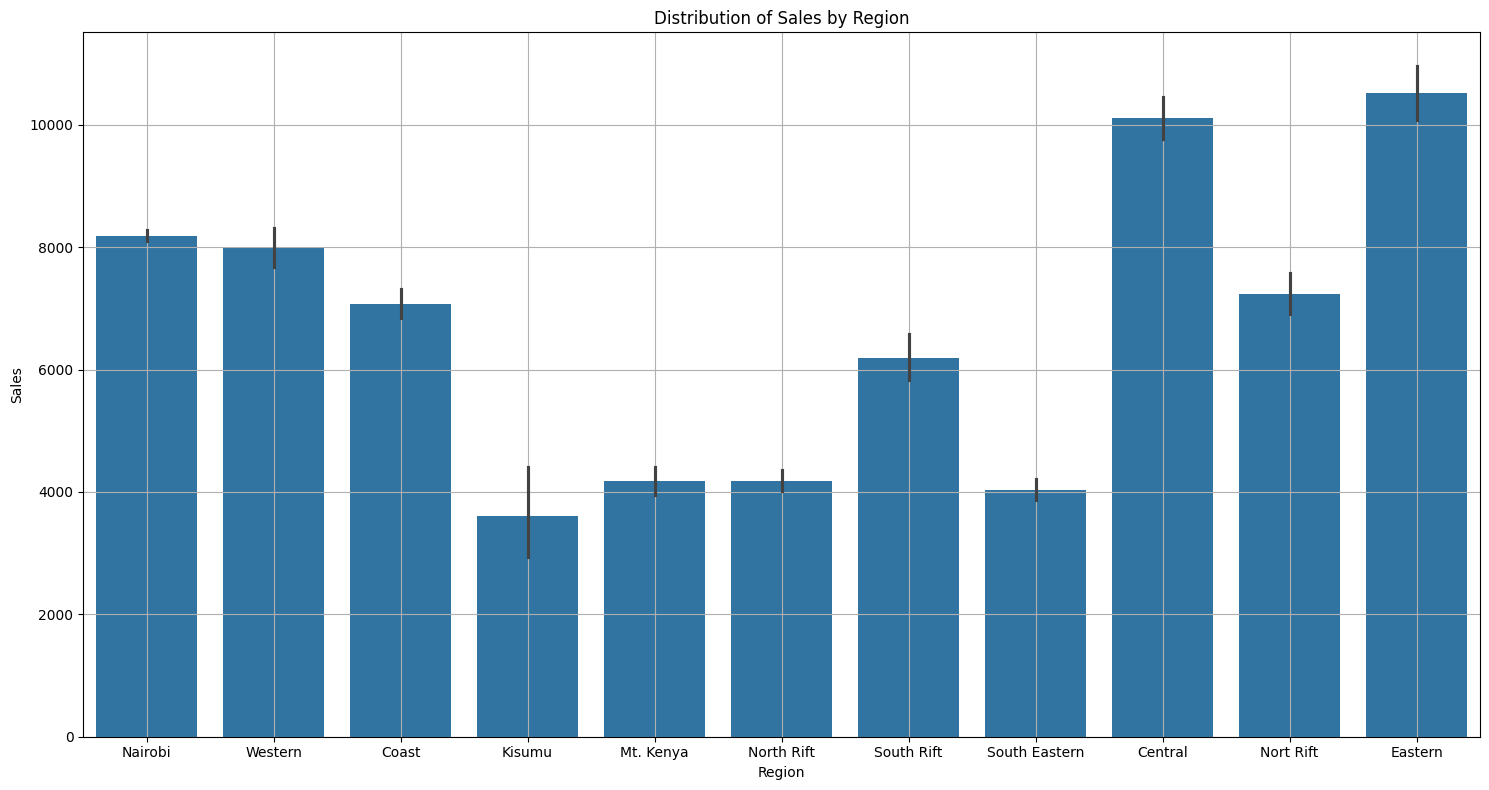

In [ ]:
# By Regional sales
plt.figure(figsize=(15, 8))
sns.barplot(data=df, x='Region', y='Sales')
plt.title('Distribution of Sales by Region')
plt.xlabel('Region')
plt.ylabel('Sales')

plt.grid(True)
plt.tight_layout()
plt.show()

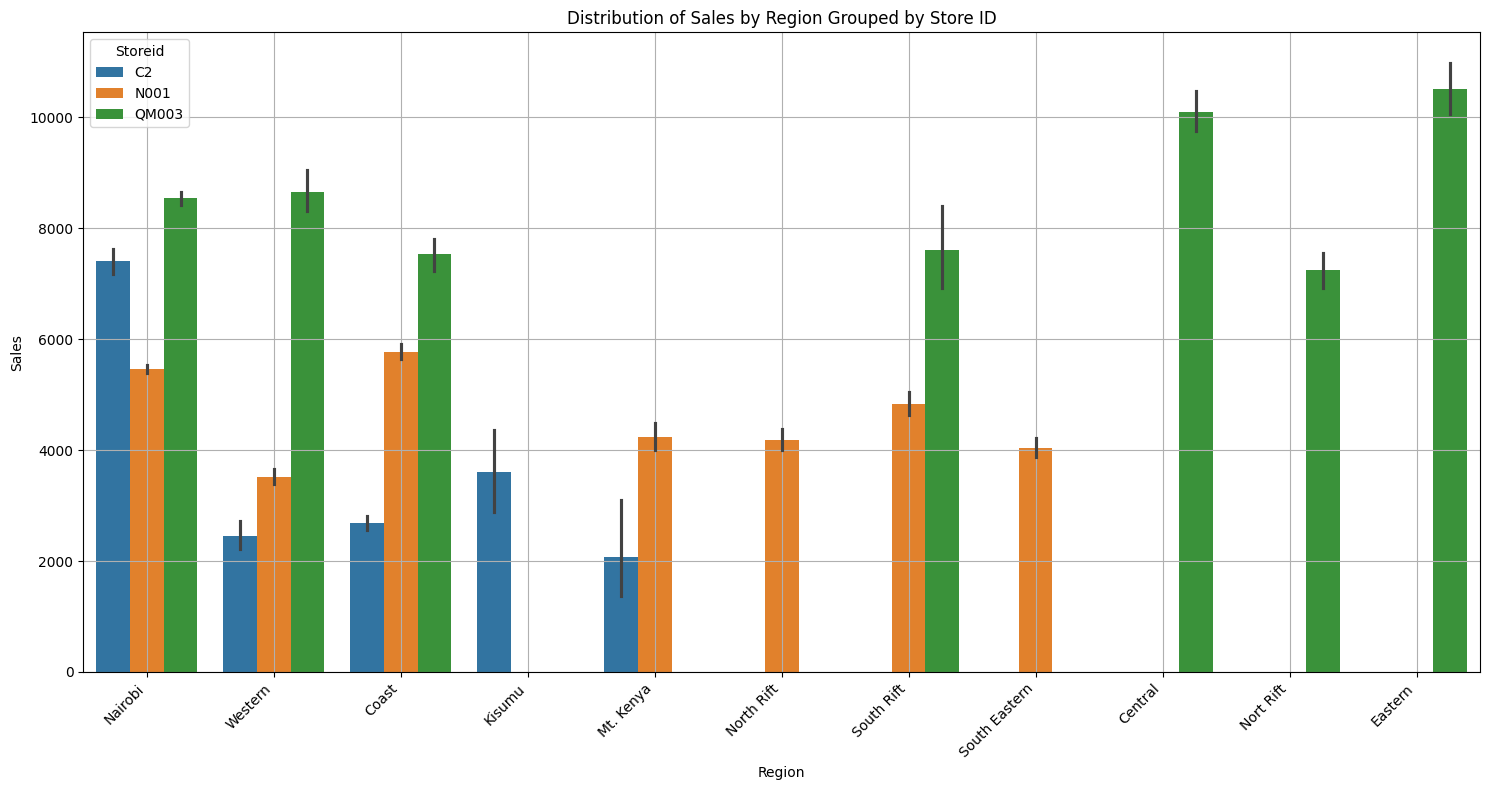

In [ ]:
# Visualize regional sales distribution grouped by store ID
plt.figure(figsize=(15, 8))
sns.barplot(data=df, x='Region', y='Sales', hue='Storeid')
plt.title('Distribution of Sales by Region Grouped by Store ID')
plt.xlabel('Region')
plt.ylabel('Sales')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Group sales by Store ID and calculate the mean sales
store_sales_mean = df.groupby('Storeid')['Sales'].mean().sort_values(ascending=False)

# Print the results
print("Mean Sales by Store ID:")
print(store_sales_mean)

# Visualise the results (optional, depending on how many stores there are)
# If you have many stores, a bar plot might be better than a pie chart.
plt.figure(figsize=(10, 6))
store_sales_mean.plot(kind='bar', color=sns.color_palette('viridis', len(store_sales_mean)))
plt.title('Mean Sales by Store ID')
plt.xlabel('Store ID')
plt.ylabel('Mean Sales')
plt.xticks(rotation=0) # Keep labels horizontal if few stores
plt.grid(axis='y')
plt.tight_layout()
plt.show()

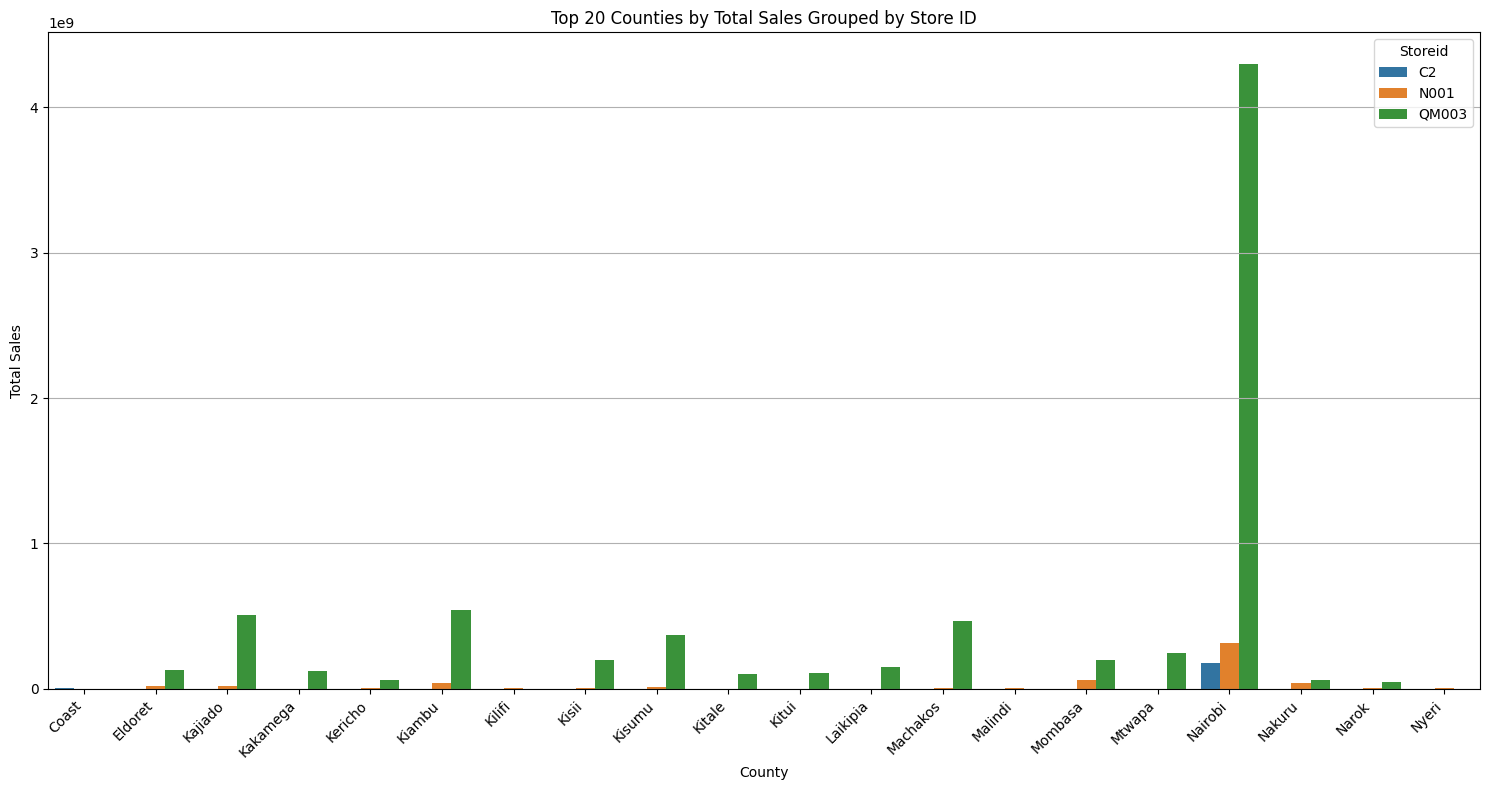

In [ ]:
# Group by County and Storeid and sum Sales
county_store_sales = df.groupby(['County', 'Storeid'])['Sales'].sum().reset_index()

# Calculate total sales per county to find the top 20 counties
county_total_sales = df.groupby('County')['Sales'].sum().sort_values(ascending=False).head(20)

# Filter the grouped data to include only the top 20 counties
top_20_county_store_sales = county_store_sales[county_store_sales['County'].isin(county_total_sales.index)]

# Create a grouped bar plot
plt.figure(figsize=(15, 8))
sns.barplot(data=top_20_county_store_sales, x='County', y='Sales', hue='Storeid')
plt.title('Top 20 Counties by Total Sales Grouped by Store ID')
plt.xlabel('County')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

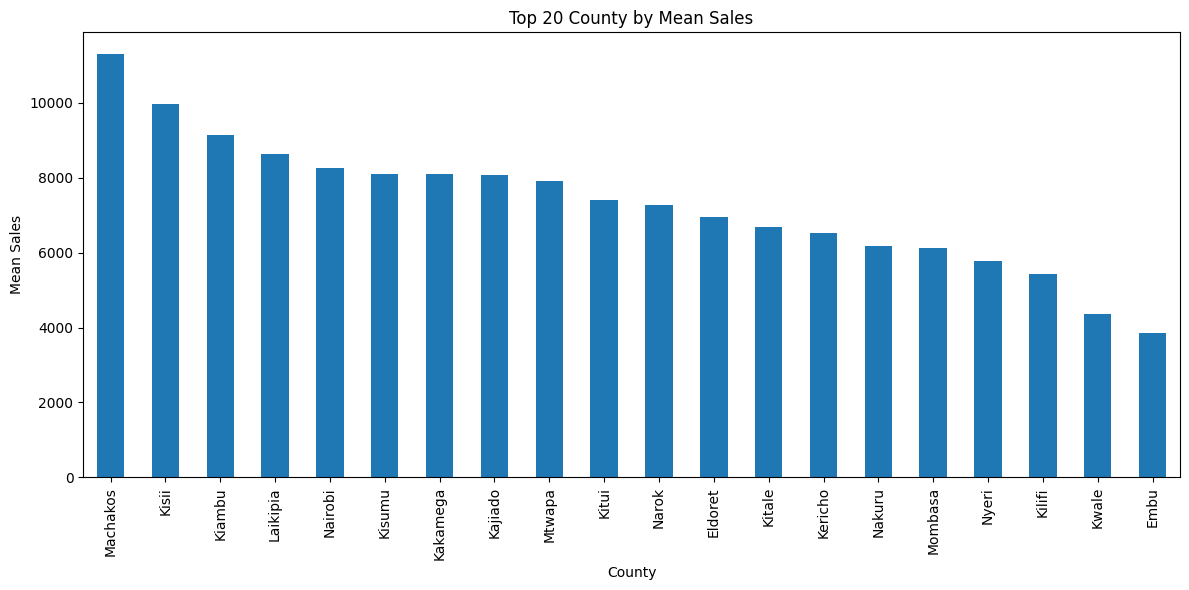

In [ ]:
# Top 20 county by mean sales
top_county = df.groupby('County')['Sales'].mean().sort_values(ascending=False).head(20)
# print(top_county)

# Visual
top_county.plot(kind='bar', figsize=(12,6))
plt.ylabel('Mean Sales')
plt.title('Top 20 County by Mean Sales')
plt.tight_layout()
plt.show()

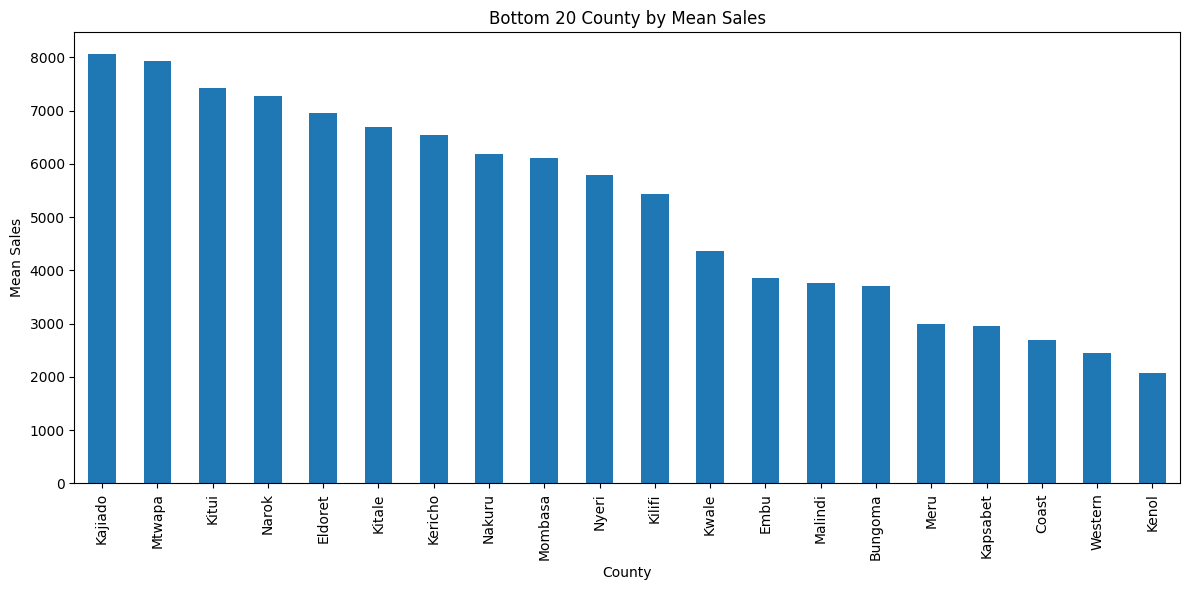

In [ ]:
# Bottom 20 County by mean sales
bottom_county = df.groupby('County')['Sales'].mean().sort_values(ascending=False).tail(20)
# print(top_county)

# Visual
bottom_county.plot(kind='bar', figsize=(12,6))
plt.ylabel('Mean Sales')
plt.title('Bottom 20 County by Mean Sales')
plt.tight_layout()
plt.show()

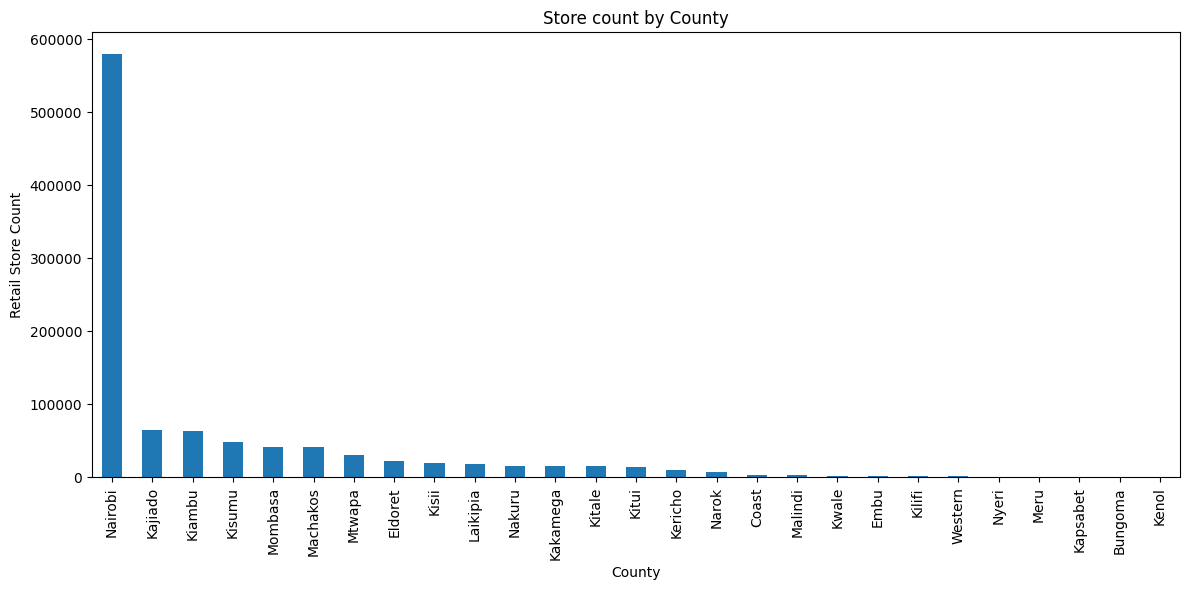

In [ ]:
# Retail store distribution by county
top_county = df.groupby('County')['Storeid'].count().sort_values(ascending=False)
# print(top_county)

# Visual
top_county.plot(kind='bar', figsize=(12,6))
plt.ylabel('Retail Store Count')
plt.title('Store count by County')
plt.tight_layout()
plt.show()

#### checking outliers in the regional distribution

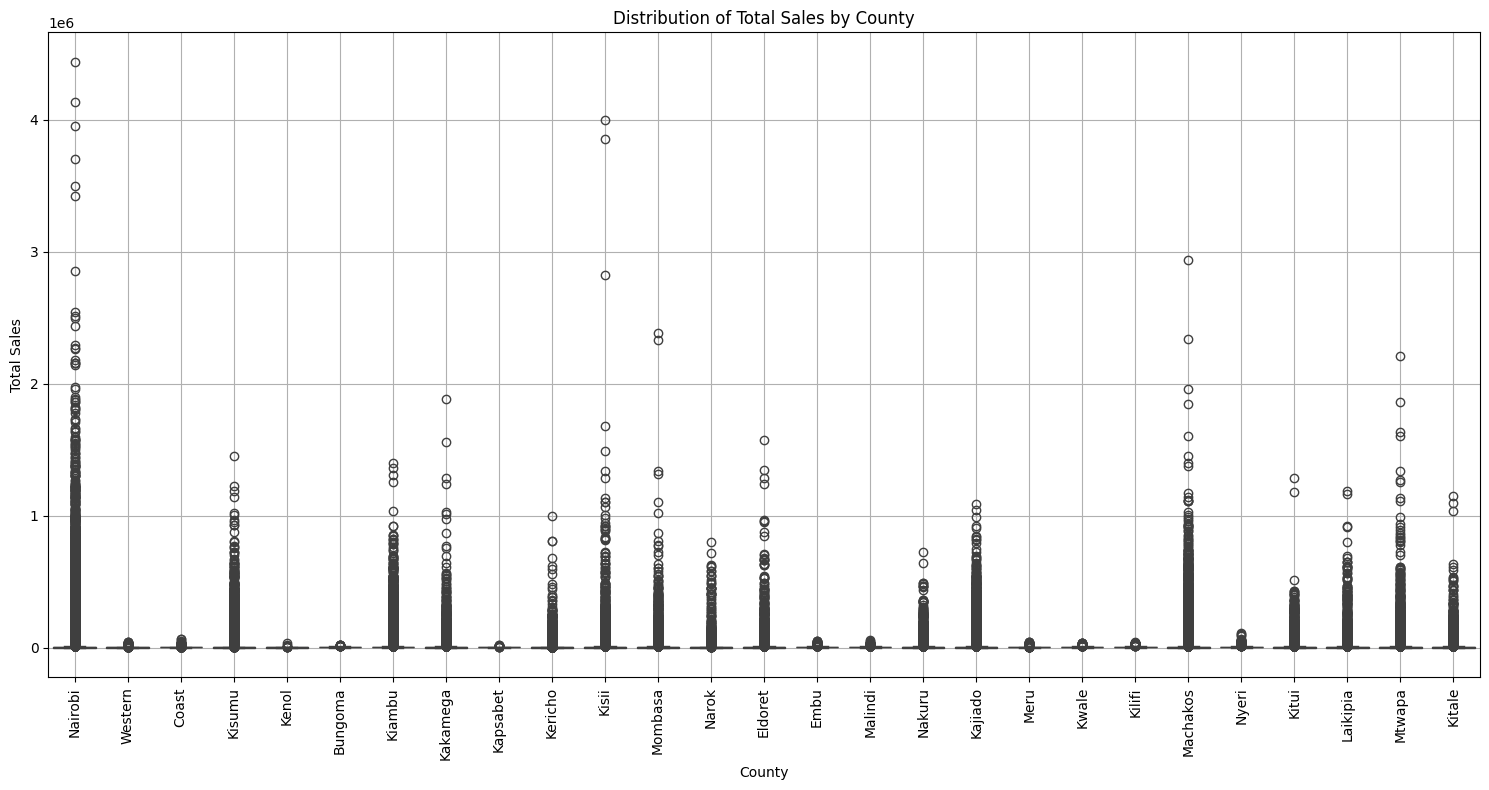

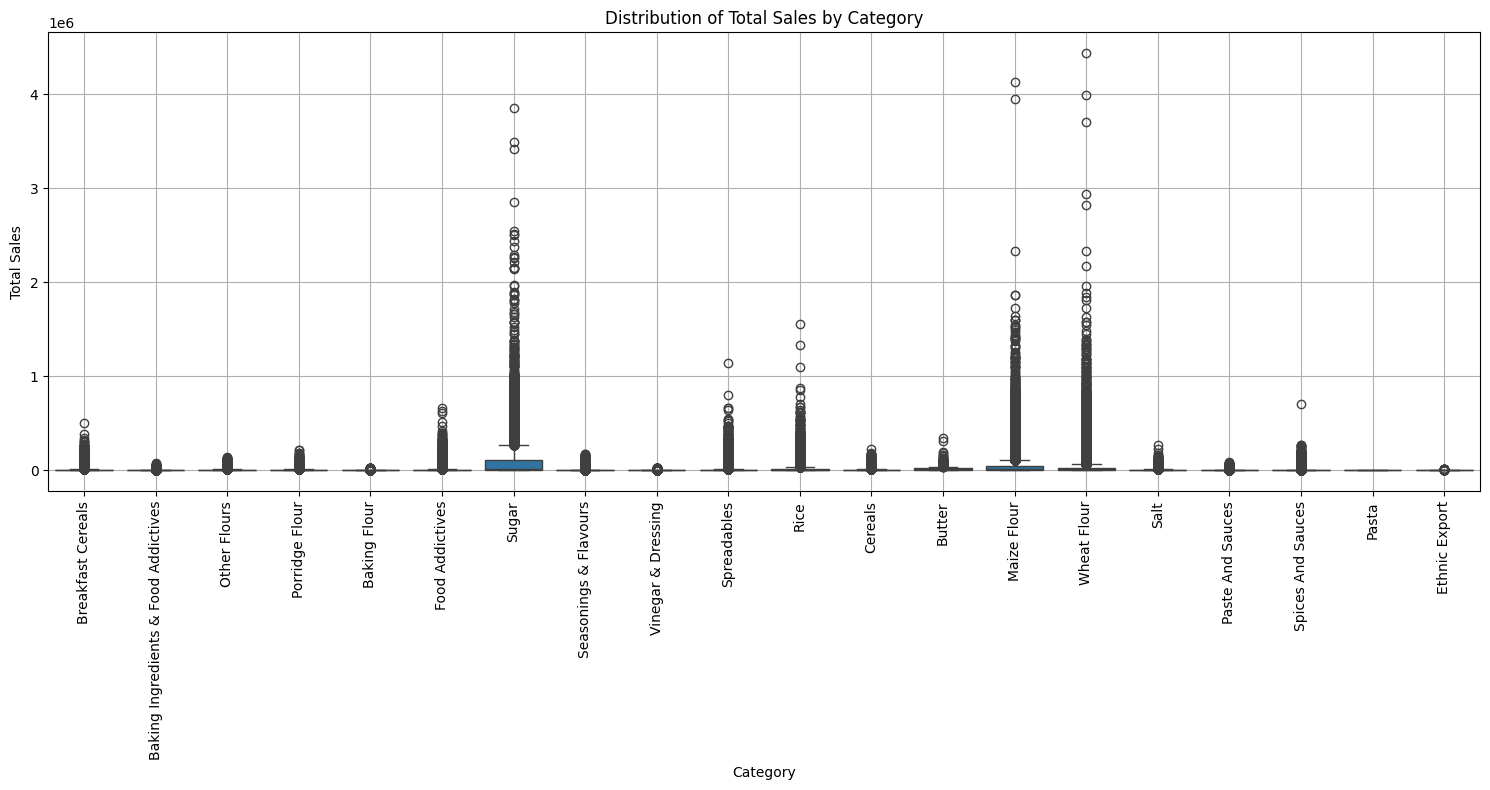

In [ ]:
# Visualize the relationship between County and TOTAL_SALES
plt.figure(figsize=(15, 8))
sns.boxplot(data=df, x='County', y='Sales')
plt.title('Distribution of Total Sales by County')
plt.xlabel('County')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize the relationship between CATEGORY and TOTAL_SALES
plt.figure(figsize=(15, 8))
sns.boxplot(data=df, x='Category', y='Sales')
plt.title('Distribution of Total Sales by Category')
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Analyze the effect of Month on Total Sales
# plt.figure(figsize=(10, 6))
# sns.boxplot(data=df_cleaned, x='month', y='TOTAL_SALES')
# plt.title('Distribution of Total Sales by Month')
# plt.xlabel('Month')
# plt.ylabel('Total Sales')
# plt.grid(True)
# plt.show()

#### Department & Category Visualisation

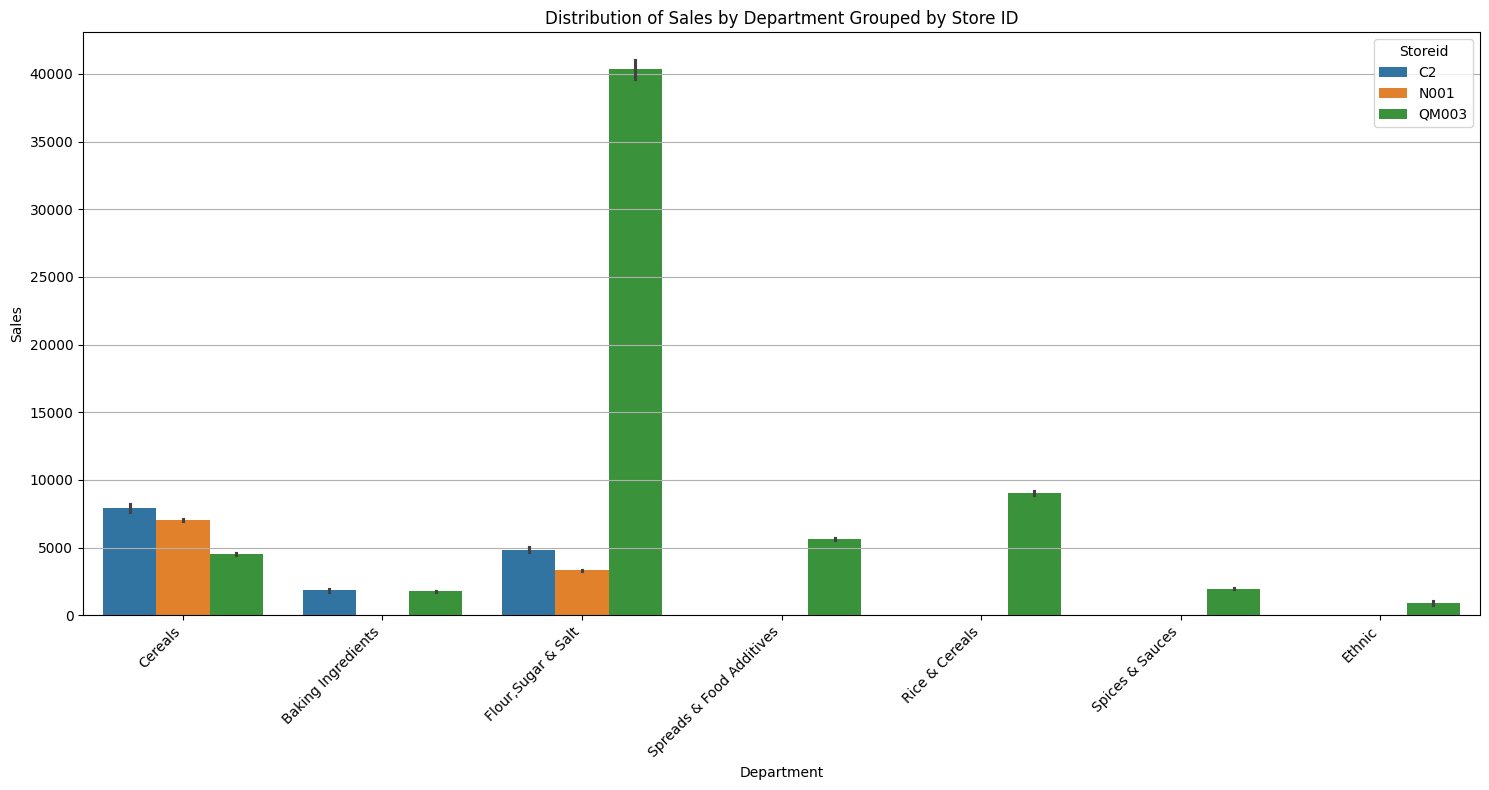

In [ ]:
# Visualize the distribution of sales by Department grouped by Store ID
plt.figure(figsize=(15, 8))
sns.barplot(data=df, x='Department', y='Sales', hue='Storeid')
plt.title('Distribution of Sales by Department Grouped by Store ID')
plt.xlabel('Department')
plt.ylabel('Sales')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

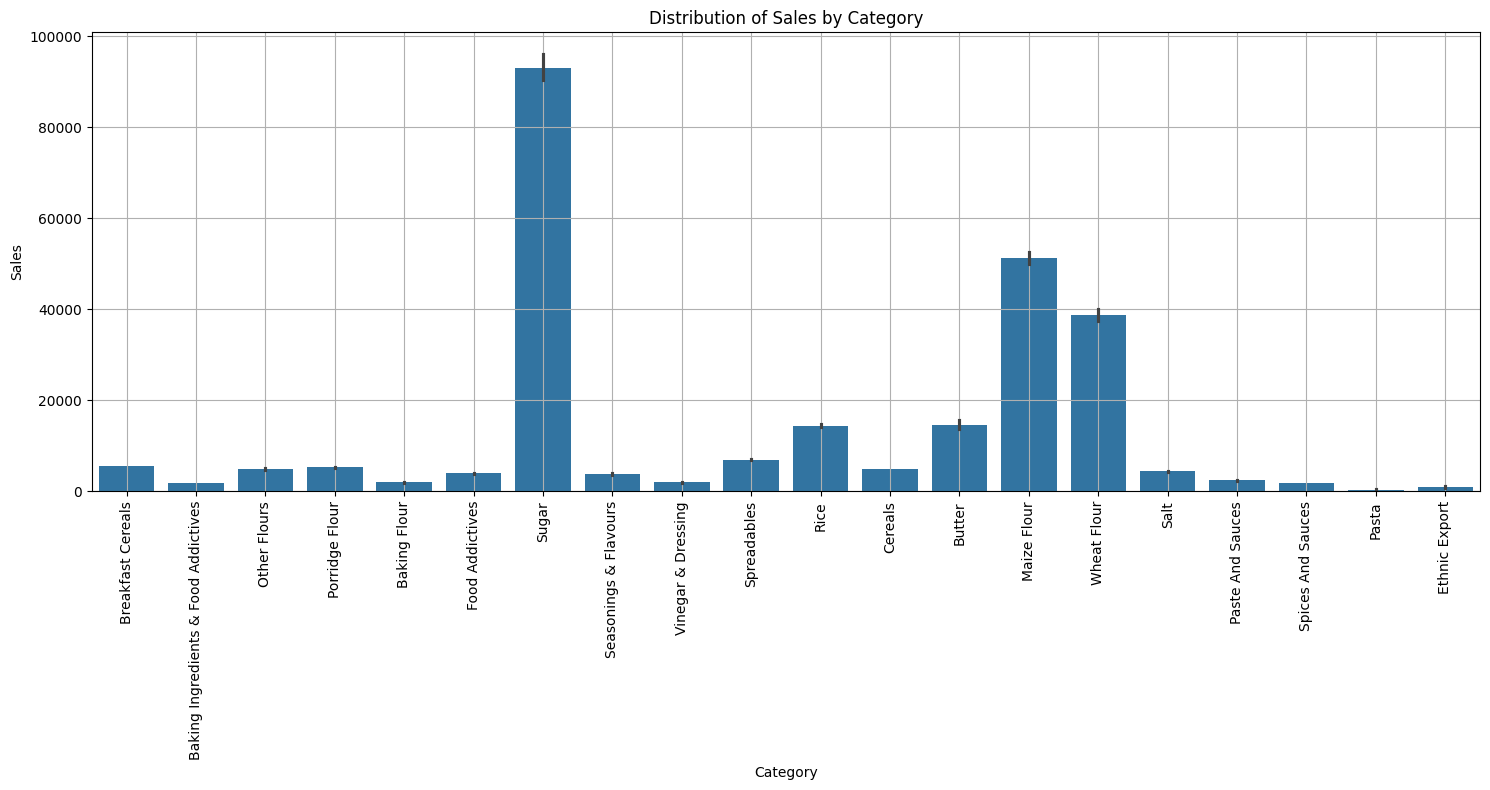

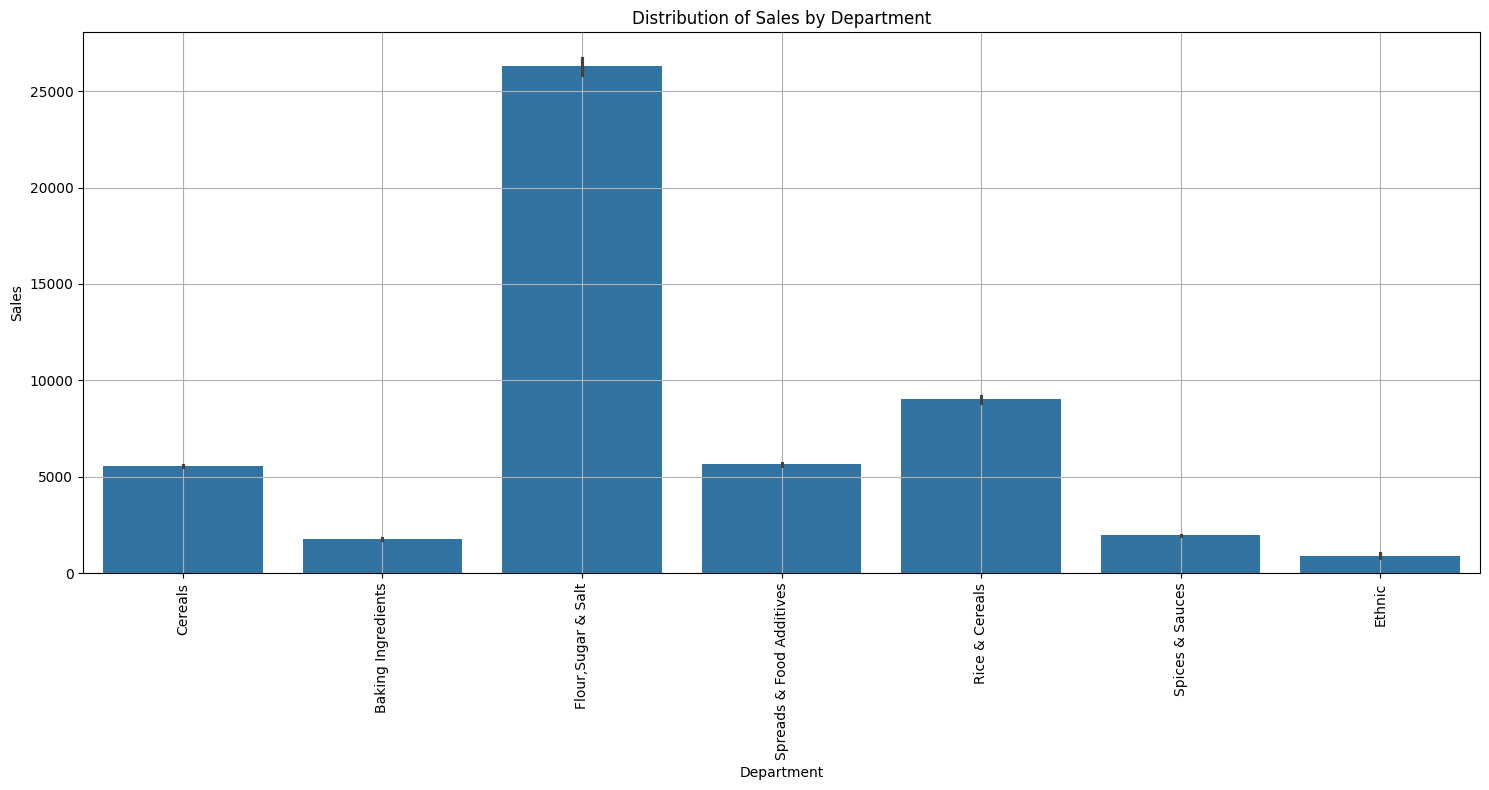

In [ ]:
# Visualize the relationship between Category and Sales
plt.figure(figsize=(15, 8))
sns.barplot(data=df, x='Category', y='Sales')
plt.title('Distribution of Sales by Category')
plt.xlabel('Category')
plt.ylabel('Sales')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize the relationship between Department and Sales
plt.figure(figsize=(15, 8))
sns.barplot(data=df, x='Department', y='Sales')
plt.title('Distribution of Sales by Department')
plt.xlabel('Department')
plt.ylabel('Sales')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize the relationship between Brand and Sales
# plt.figure(figsize=(15, 8))
# sns.barplot(data=df, x='Brand', y='Sales')
# plt.title('Distribution of Sales by Brand')
# plt.xlabel('Brand')
# plt.ylabel('Sales')
# plt.xticks(rotation=90)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:
### sales by department
Depart_sales = df.groupby('Department')['Sales'].mean().sort_values(ascending=False)
print("Sales by Department")
print(Depart_sales)

Sales by Department
Department
Flour,Sugar & Salt          26299.117170
Rice & Cereals               9006.723806
Spreads & Food Additives     5634.613962
Cereals                      5544.606684
Spices & Sauces              1957.271726
Baking Ingredients           1766.800364
Ethnic                        909.172957
Name: Sales, dtype: float64


#### Brand Analysis

Brand
Mumias             333392.019044
West Kenya         295342.195651
Butali             268177.822341
Sukari             227487.664950
Copia              173589.883182
Uwezo              160917.399933
Perfect Trade      137572.607606
Transmara          132561.232954
Mac                111503.031422
Max Grains          97740.016841
Grain               91670.233956
Ajab                66326.278502
Quickmart           61913.956445
Joymax              61170.764748
Buffalo             60507.825886
Eastern             54769.428571
Kenblest            47233.887189
Mombasa Millers     45673.543247
Spenza              42905.003973
Mama Millers        41739.233026
Name: Sales, dtype: float64


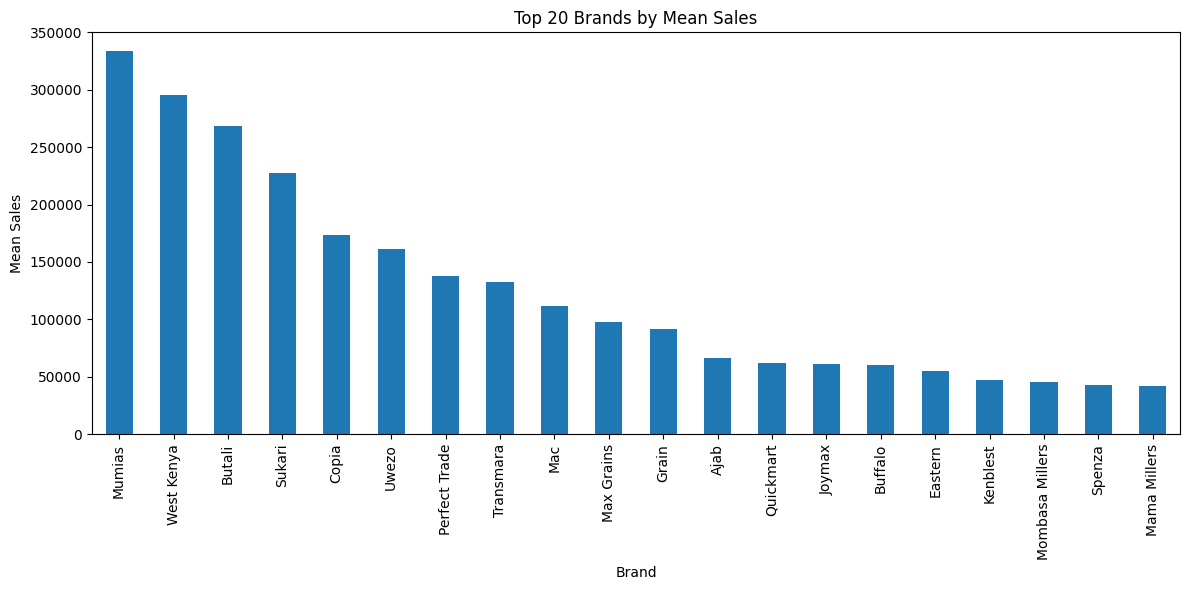

In [ ]:
# Top 20 Brands by mean sales
top_brands = df.groupby('Brand')['Sales'].mean().sort_values(ascending=False).head(20)
print(top_brands)

# Visual
top_brands.plot(kind='bar', figsize=(12,6))
plt.ylabel('Mean Sales')
plt.title('Top 20 Brands by Mean Sales')
plt.tight_layout()
plt.show()

Brand
Fixcorp         486.270148
Orchards        478.651582
Beret           472.413750
Likii           454.381825
Meam Tasytee    450.564613
Planet          450.225103
Shamilar        420.142492
Dr Oetker       396.550000
Mace            383.379342
Pradip          374.459527
Firstcup        371.963704
Julimatt        362.285714
Yash            349.365228
Henry'S         307.725764
Annapurna       274.087182
Haco            258.620600
Jumba           155.000000
Kirinyaga       155.000000
Sun             147.000000
Ruby             96.551714
Name: Sales, dtype: float64


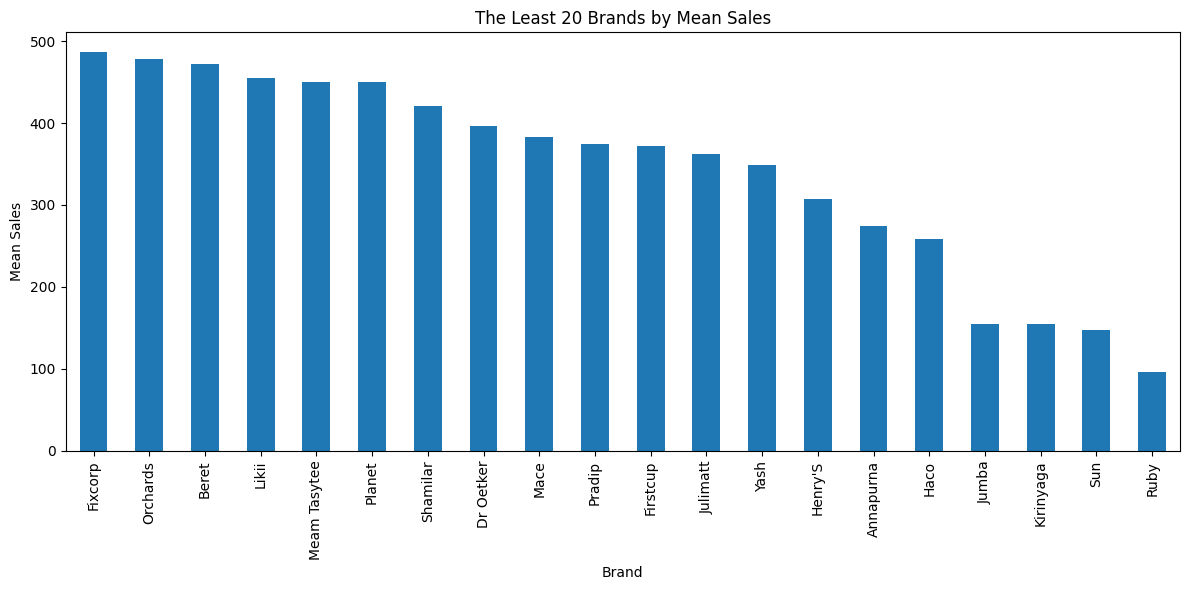

In [ ]:
# Top least performin Brands by mean sales
bottom_brands = df.groupby('Brand')['Sales'].mean().sort_values(ascending=False).tail(20)
print(bottom_brands)

# Visual
bottom_brands.plot(kind='bar', figsize=(12,6))
plt.ylabel('Mean Sales')
plt.title('The Least 20 Brands by Mean Sales')
plt.tight_layout()
plt.show()

### Product analysis

Item_name
AJAB HOME BAKING FLOUR 2KG         503354.806133
FD-KABRAS SUGAR WHITE 2KG          446019.907905
CAP SOKO MAIZE FLOUR 2KG           385741.658854
BUTALI SUGAR 2KG                   378738.739267
SAFI MAIZE MEAL 2KG                375411.665678
KABRAS SUGAR WHITE 2KG             369517.376645
FD-MUMIAS SUGAR 2 KG               368489.714511
MUMIAS SUGAR 2 KG                  341634.630849
FD-AJAB HOME BAKING FLOUR 2KG      340003.436633
QUICK CHOICE SUGAR 2KG             282568.821546
SKI NDHIWA SUGAR 2KG               282105.647613
NUTRAMEAL SUGAR 2KG                268137.056351
TAIFA MAIZE MEAL 2KG               239766.568558
FD-KABRAS SUGAR WHITE 1KG          234737.917691
FD-RAHA PREMIUM MAIZE MEAL 2 KG    224369.151807
KCL-SUNSUGAR BROWN 1 KG            209331.820000
FD-CAP SOKO MAIZE FLOUR 2KG        207179.095181
FD-EXE ALL PURPOSE FLOUR 2KG       204249.064346
JOGOO MAIZE MEAL 2KG               190616.087893
RAHA PREMIUM MAIZE MEAL 2 KG       187960.747282
Name: Sale

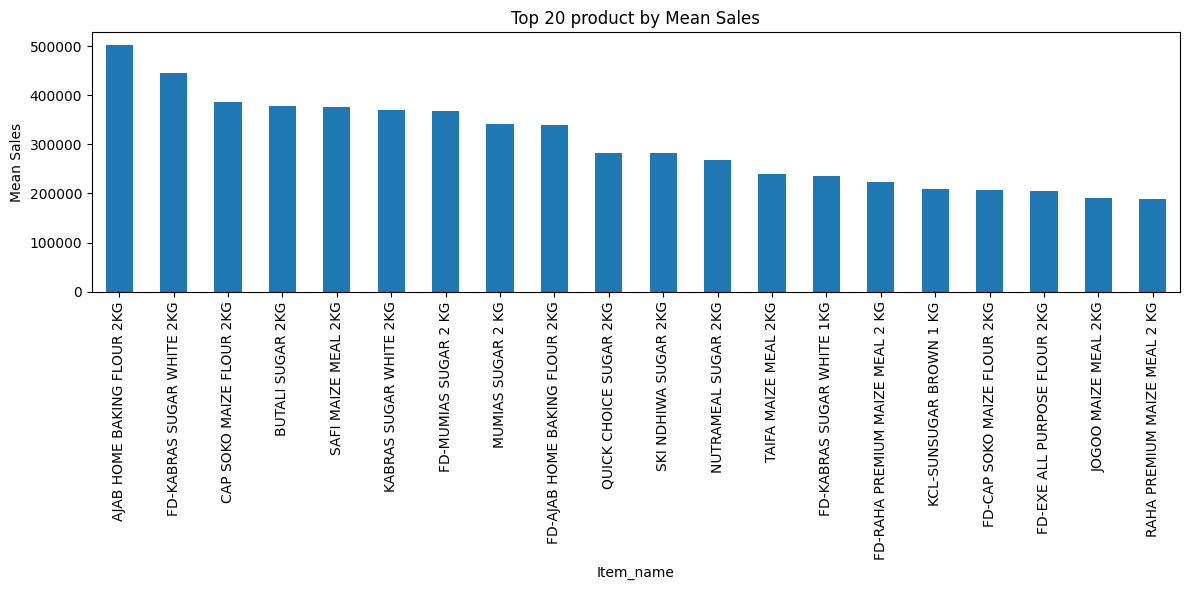

In [ ]:
# Top 20 product by mean sales
top_products = df.groupby('Item_name')['Sales'].mean().sort_values(ascending=False).head(20)
print(top_products)

# Visual
top_products.plot(kind='bar', figsize=(12,6))
plt.ylabel('Mean Sales')
plt.title('Top 20 product by Mean Sales')
plt.tight_layout()
plt.show()

#### Monthly trend

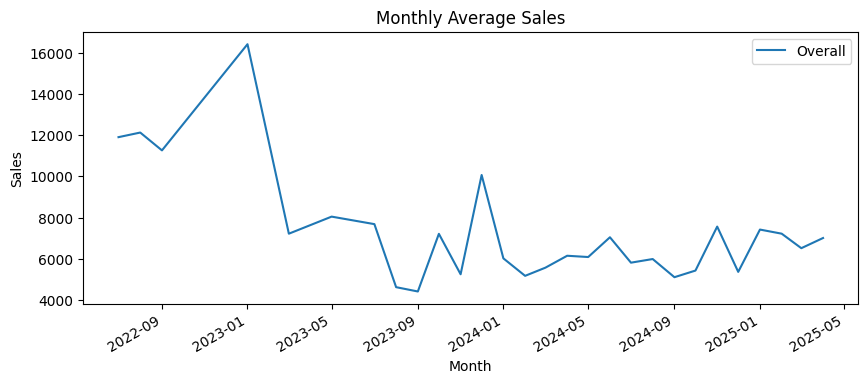

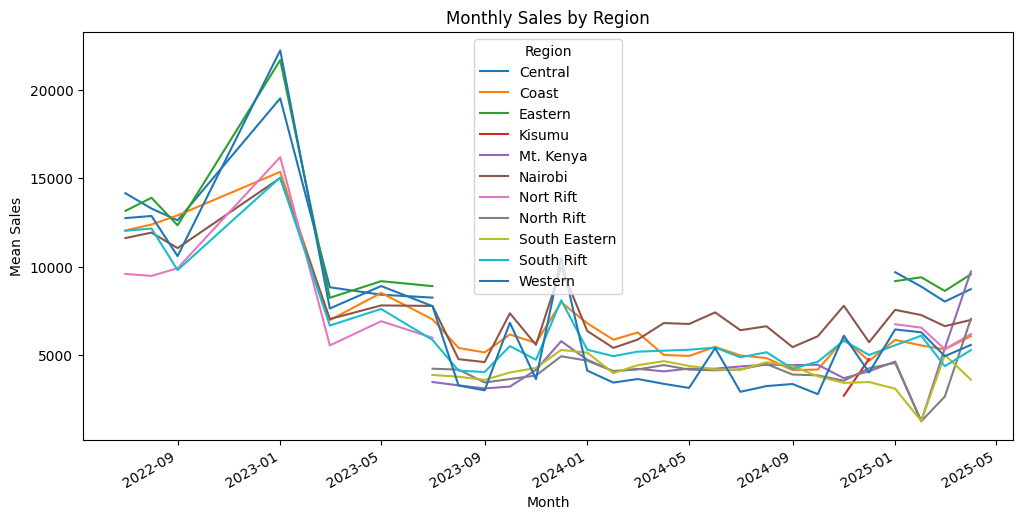

In [ ]:

trend = df.groupby('Month')['Sales'].mean()
trend.plot(label='Overall', figsize=(10,4))
plt.title('Monthly Average Sales')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.show()

# By Region over time
trend_region = df.groupby(['month','Region'])['Sales'].mean().unstack()
trend_region.plot(figsize=(12,6))
plt.title('Monthly Sales by Region')
plt.ylabel('Mean Sales')
plt.show()

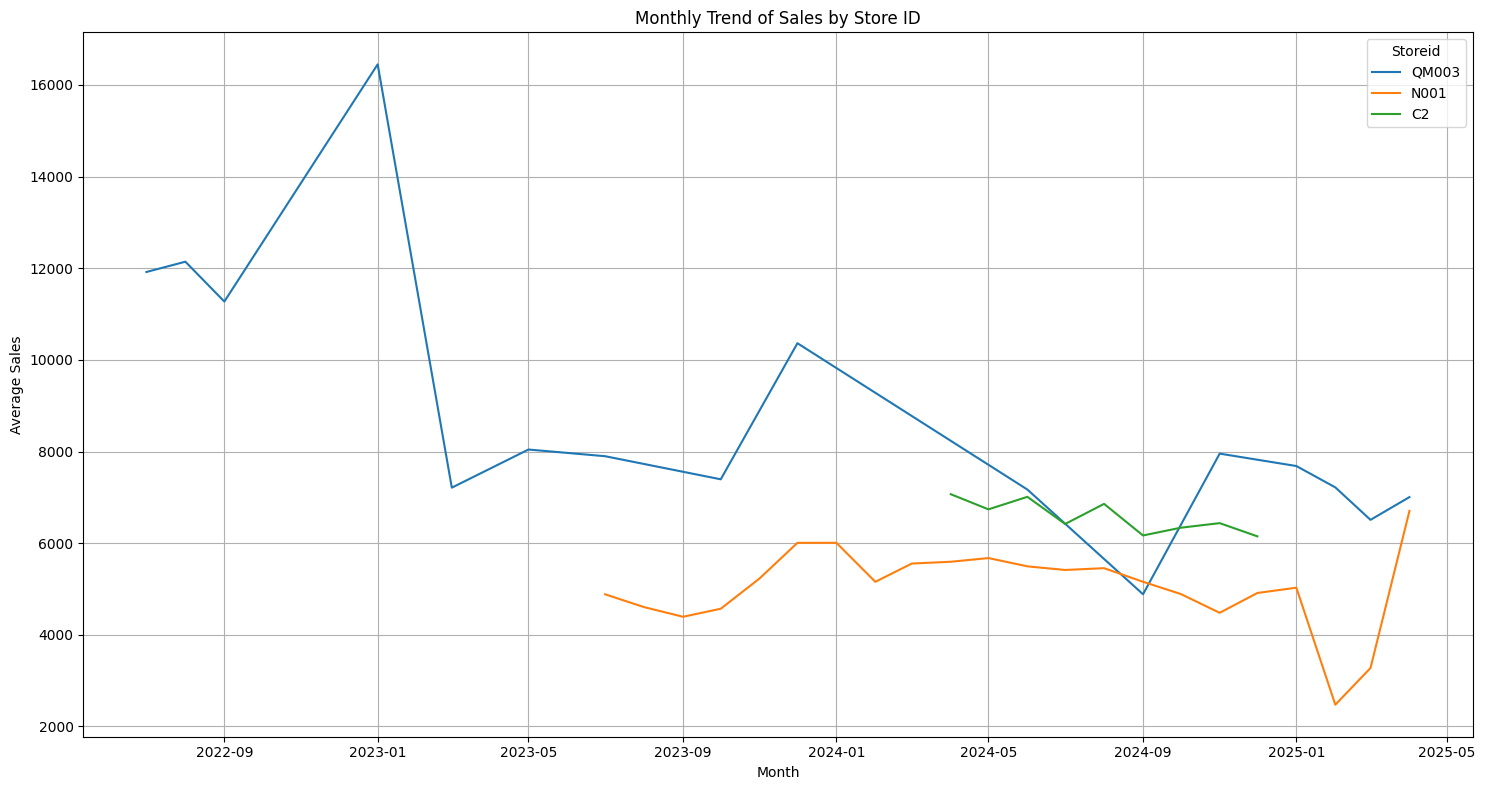

In [ ]:
# Monthly trend of sales grouped by Store ID
monthly_trend_store = df.groupby(['Month', 'Storeid'])['Sales'].mean().reset_index()

# Combine year and month for plotting
monthly_trend_store['YearMonth'] = pd.to_datetime(monthly_trend_store['Month'].astype(str))

plt.figure(figsize=(15, 8))
sns.lineplot(data=monthly_trend_store, x='YearMonth', y='Sales', hue='Storeid')
plt.title('Monthly Trend of Sales by Store ID')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

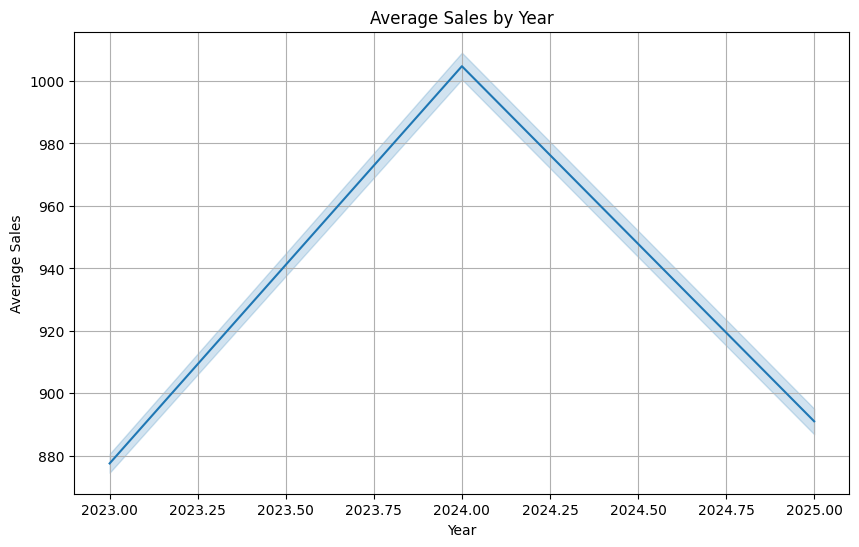

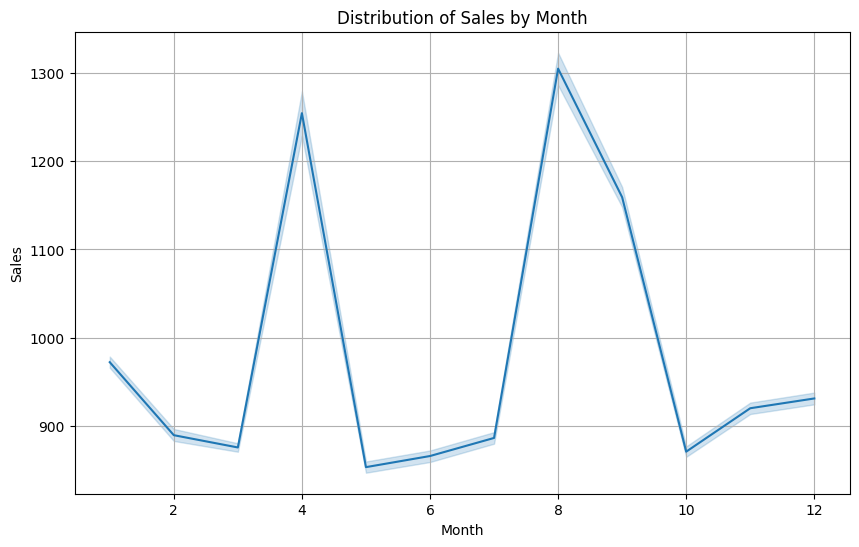

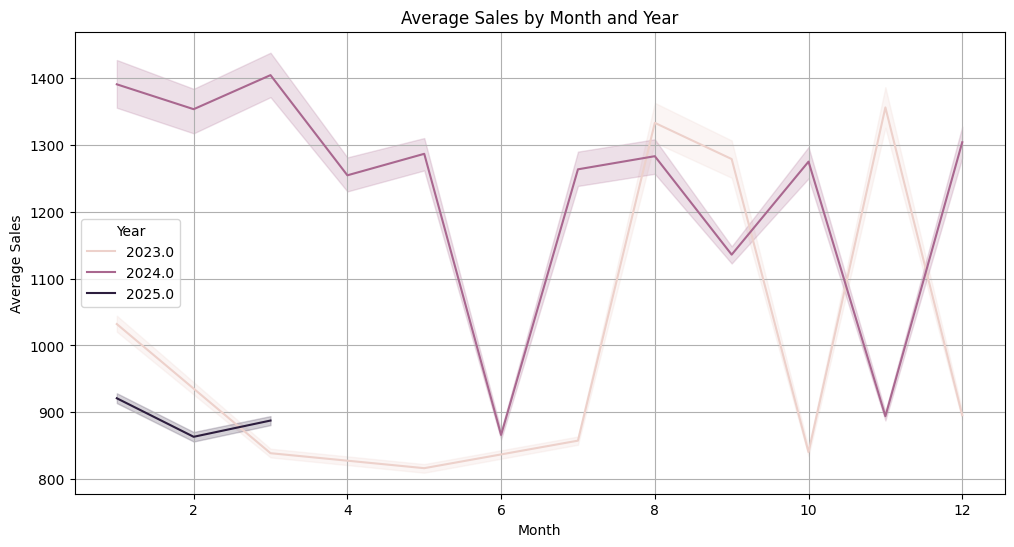

In [ ]:
# Analyze the effect of Year on Total Sales
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_cleaned, x='year', y='Sales', estimator='mean')
plt.title('Average Sales by Year')
plt.xlabel('Year')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()

# Analyze the effect of Month on Total Sales
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_cleaned, x='month', y='Sales')
plt.title('Distribution of Sales by Month')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

# combined effect of year and month
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_cleaned, x='month', y='Sales', hue='year', estimator='mean')
plt.title('Average Sales by Month and Year')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.grid(True)
plt.legend(title='Year')
plt.show()

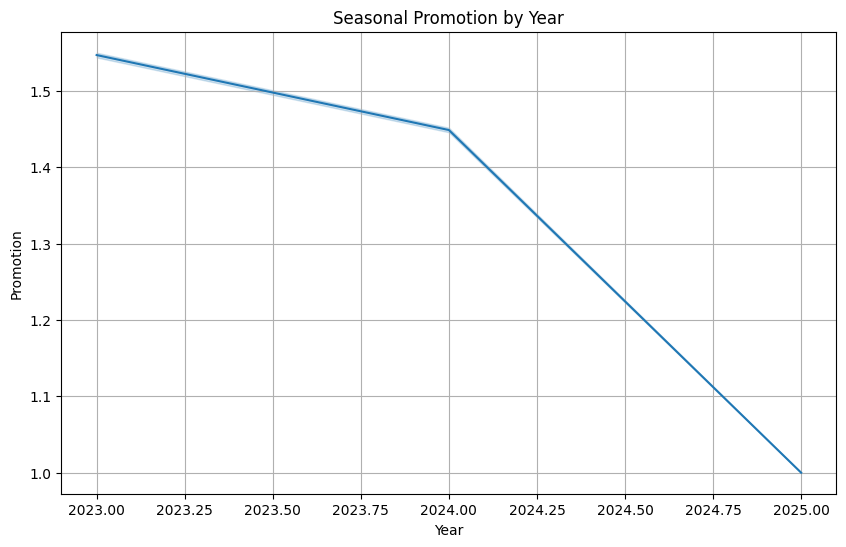

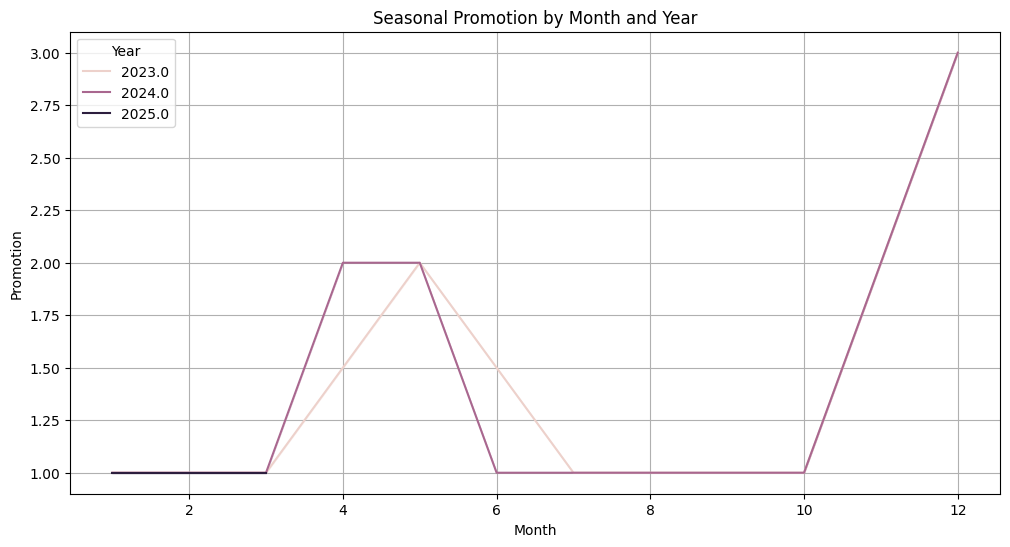

In [ ]:
# Analyze the effect of Year on Total Sales
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_cleaned, x='year', y='Promotion')
plt.title('Seasonal Promotion by Year')
plt.xlabel('Year')
plt.ylabel('Promotion')
plt.grid(True)
plt.show()


# combined effect of year and month
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_cleaned, x='month', y='Promotion', hue='year')
plt.title('Seasonal Promotion by Month and Year')
plt.xlabel('Month')
plt.ylabel('Promotion')
plt.grid(True)
plt.legend(title='Year')
plt.show()

#### Cross Category dependancies

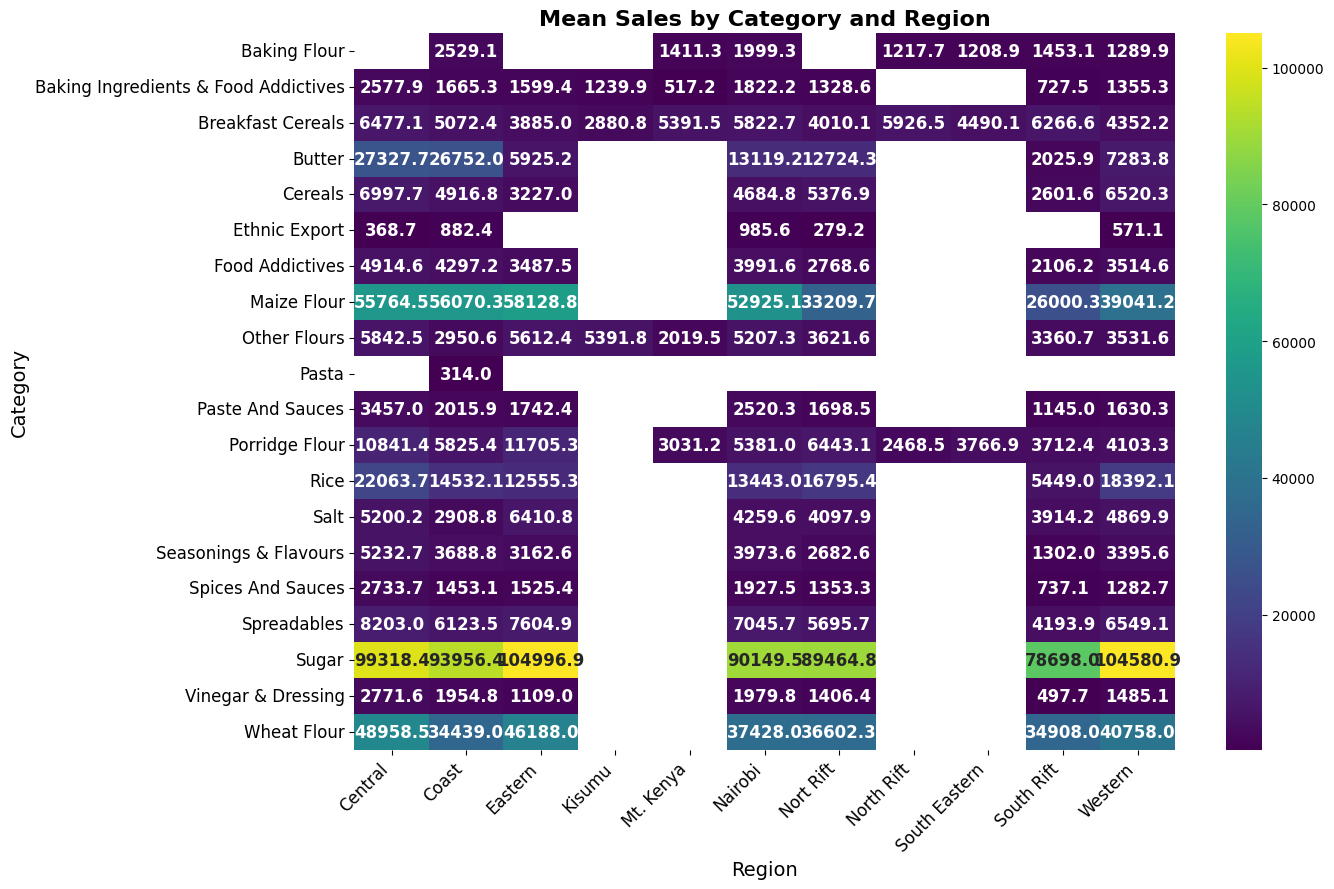

In [ ]:
# Mean sales by Category and Region (pivot table)
mean_by_cat_region = df.pivot_table(values='Sales', index='Category', columns='Region', aggfunc='mean')

# Heatmap with larger visual
plt.figure(figsize=(14, 9))  # larger figure
sns.heatmap(
    mean_by_cat_region,
    annot=True,
    fmt=".1f",
    cmap="viridis",
    annot_kws={"size": 12, "weight": "bold"}  # make numbers larger and readable
)

# Increase font sizes for axes and title
plt.title('Mean Sales by Category and Region', fontsize=16, fontweight='bold')
plt.xlabel('Region', fontsize=14)
plt.ylabel('Category', fontsize=14)

# Improve tick visibility
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

# Interaction effect hints: differences across regions
df['Category_Region'] = df['Category'] + " | " + df['Region']
interaction_stats = df.groupby('Category_Region')['Sales'].agg(['count','mean','std']).sort_values('mean', ascending=False)
# print(interaction_stats)

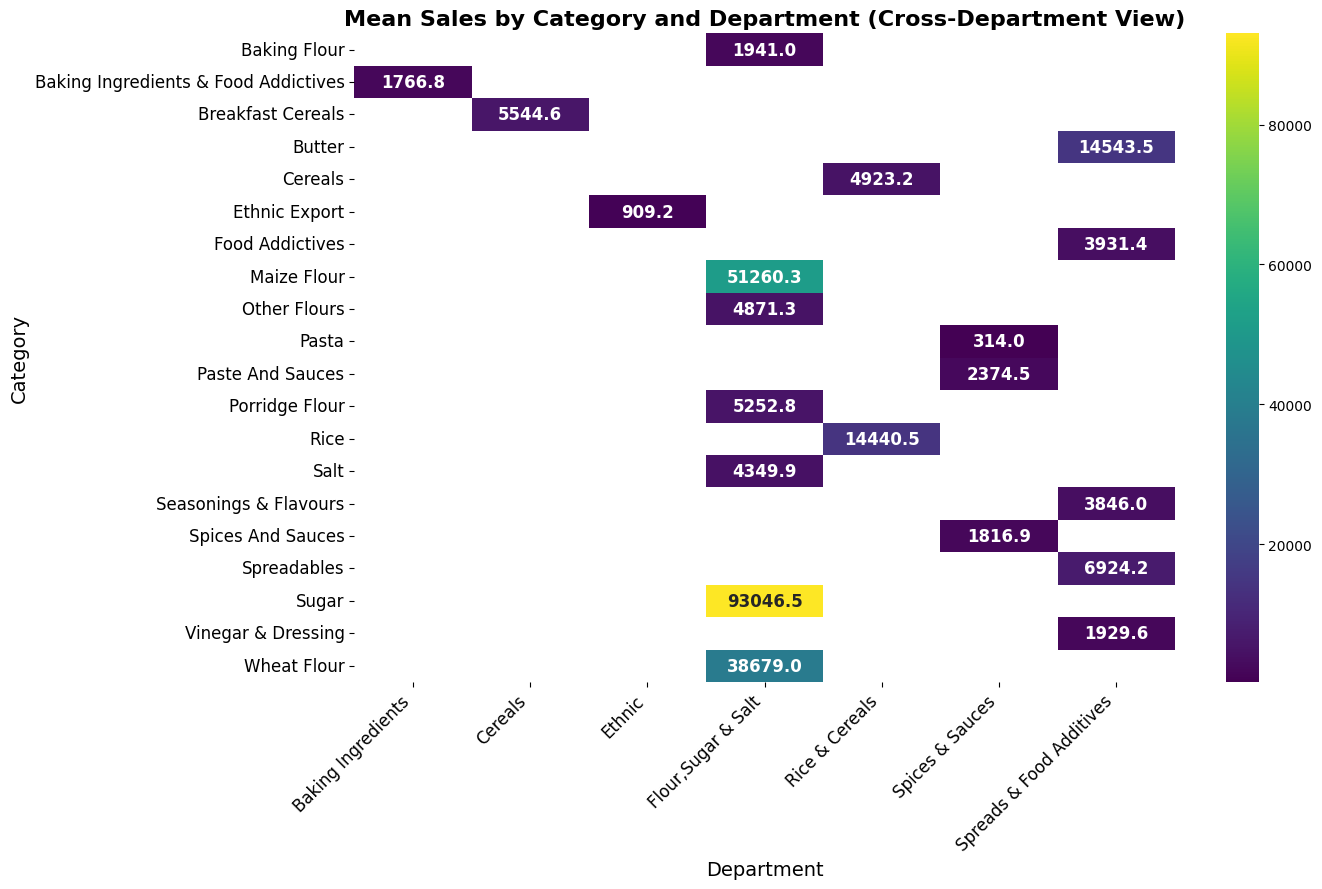

In [ ]:
# Cross-Department Understanding and Sales

# Mean sales by Category and Department (pivot table)
mean_by_cat_dept = df.pivot_table(values='Sales', index='Category', columns='Department', aggfunc='mean')

# Debug: ensure the pivot is not empty
if mean_by_cat_dept.empty:
    print("Pivot table is empty. Check that 'Category' and 'Department' exist in df and have data.")
else:
    # Heatmap with larger visual for cross-department understanding
    plt.figure(figsize=(14, 9))  # larger figure for readability
    sns.heatmap(
        mean_by_cat_dept,
        annot=True,
        fmt=".1f",
        cmap="viridis",
        annot_kws={"size": 12, "weight": "bold"}  # larger, bold numbers
    )

    plt.title('Mean Sales by Category and Department (Cross-Department View)', fontsize=16, fontweight='bold')
    plt.xlabel('Department', fontsize=14)
    plt.ylabel('Category', fontsize=14)

    plt.xticks(fontsize=12, rotation=45, ha='right')
    plt.yticks(fontsize=12)

    plt.tight_layout()
    plt.show()

# Interaction effect hints for cross-department understanding: differences across departments within each category
# Create a cross-department interaction feature
df['Category_Department'] = df['Category'] + " | " + df['Department']

interaction_stats = df.groupby('Category_Department')['Sales'].agg(['count','mean','std']).sort_values('mean', ascending=False)
# print(interaction_stats)

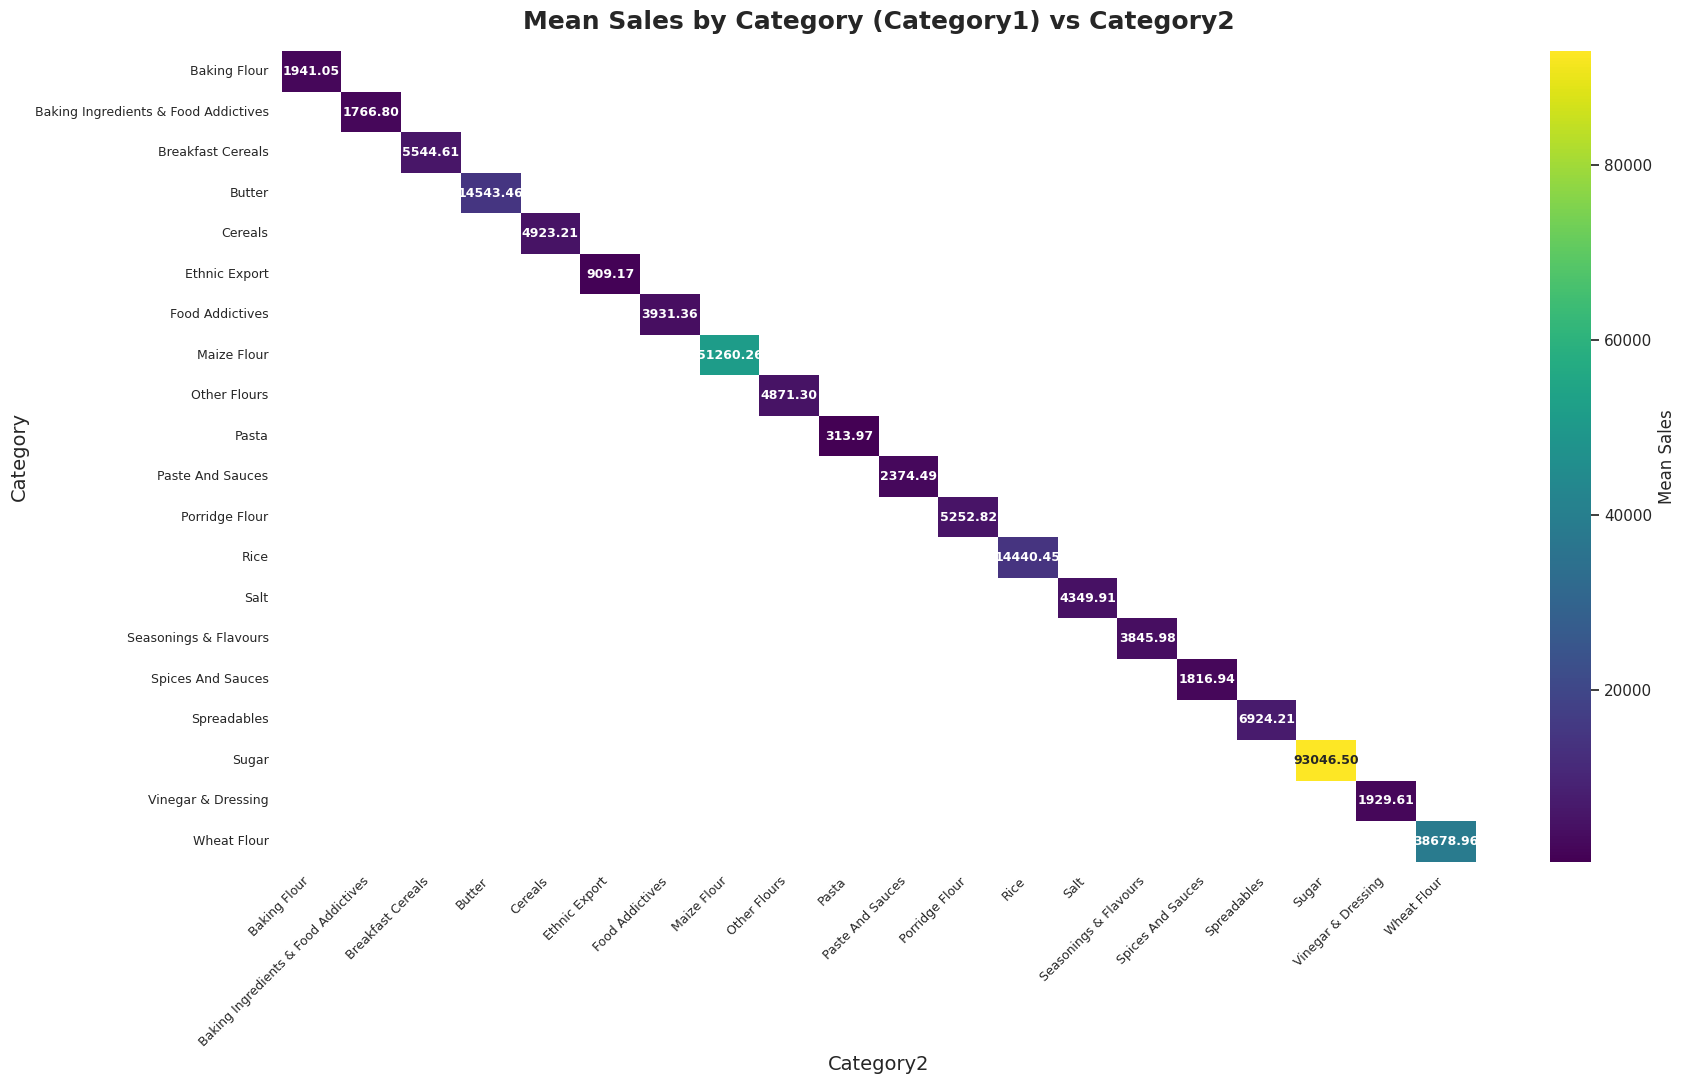

In [ ]:
# Cross-Category Heatmap with cleaned data (df)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure we have a second category dimension
if 'Category2' not in df.columns:
    # Create a meaningful surrogate if you don't have a second category
    # Option A: duplicate Category (for demonstration)
    df['Category2'] = df['Category']
    # Option B: create a binning on a numeric feature if you have one, e.g.,
    # df_cleaned['Category2'] = df_cleaned['SomeNumeric'].apply(lambda x: f"Bin_{x:.0f}")

# Compute mean Sales for each (Category, Category2)
mean_by_cat_pair = (
    df.groupby(['Category', 'Category2'])['Sales']
      .mean()
      .reset_index()
)

# Build a complete rectangular matrix
# Get all unique categories
all_categories = mean_by_cat_pair['Category'].unique()
all_category2 = mean_by_cat_pair['Category2'].unique()

# Pivot to matrix: rows=Category (Category1), cols=Category2
pivot = mean_by_cat_pair.pivot(index='Category', columns='Category2', values='Sales')

# Reindex to ensure full rectangular matrix (fill with NaN where missing)
pivot = pivot.reindex(index=pd.Index(all_categories, name='Category'),
                    columns=pd.Index(all_category2, name='Category2'))

# Optional: show a mask for missing combinations
mask = pivot.isna()

# Figure setup for readability
plt.figure(figsize=(18, 11))  # wide to accommodate many categories
sns.set(style="white")

# Main heatmap: include a color bar with label
heatmap = sns.heatmap(
    pivot,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    mask=mask,                    # mask missing combos for clarity
    cbar_kws={"label": "Mean Sales"},
    annot_kws={"size": 9, "weight": "bold"}
)

# Titles and labels
plt.title('Mean Sales by Category (Category1) vs Category2', fontsize=18, fontweight='bold', pad=16)
plt.xlabel('Category2', fontsize=14)
plt.ylabel('Category', fontsize=14)

# Improve axis readability
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)

plt.tight_layout()
plt.show()

# Optional: Delta vs Reference Category across all data (not shown by default)
# You can add a similar delta block if needed, using df_cleaned in place of df.

In [ ]:
# 1) Ensure Sub_category exists (use real second dimension; fallback if missing)
if 'Sub_category' not in df_cleaned.columns:
    df_cleaned['Sub_category'] = df_cleaned['Category']  # fallback proxy

# 2) Compute mean Sales for each (Category, Sub_category)
mean_by_pair = (
    df_cleaned.groupby(['Category', 'Sub_category'])['Sales']
    .mean()
    .reset_index()
)

# 3) Build a full rectangular matrix (rectangular grid)
all_categories = mean_by_pair['Category'].unique()
all_subcats = mean_by_pair['Sub_category'].unique()

pivot = mean_by_pair.pivot(index='Category', columns='Sub_category', values='Sales')

# Ensure full rectangle; fill missing with NaN (will appear as blank cells)
pivot = pivot.reindex(index=pd.Index(all_categories, name='Category'),
                    columns=pd.Index(all_subcats, name='Sub_category'))

# 4) Plot settings
plt.figure(figsize=(22, 12))  # wide figure for readability
sns.set(style="white")

# Show NaNs as blanks (mask = None or mask=False). If you want NaNs masked, set mask
# mask = pivot.isna()  # uncomment to mask NaNs
mask = None

ax = sns.heatmap(
    pivot,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    mask=mask,  # keep as None to show NaNs as blanks
    cbar_kws={"label": "Mean Sales"},
    annot_kws={"size": 9, "weight": "bold"}
)

# Titles and labels
ax.set_title('Mean Sales by Category (Category1) vs Sub_category', fontsize=20, fontweight='bold', pad=14)
ax.set_xlabel('Sub_category', fontsize=14)
ax.set_ylabel('Category', fontsize=14)

# Improve axis readability
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

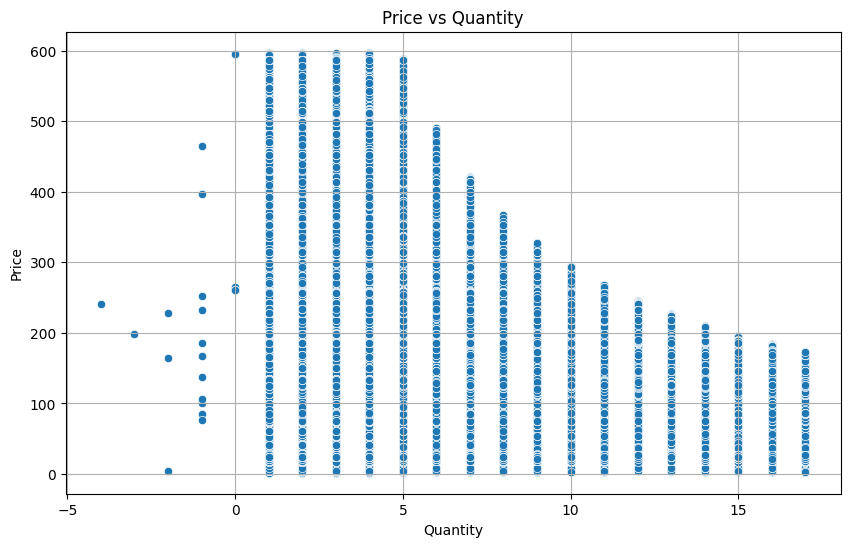

In [ ]:
# Visualize the relationship between Price and Quantity
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='Qty', y='Price')
plt.title('Price vs Quantity')
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.grid(True)
plt.show()

#### Data Preprocessing

## Treating missing values

In [5]:
# imputiing using KNNIputer
from sklearn.impute import KNNImputer
impute = KNNImputer

In [6]:
#Checking for Missing Data
total_missing = df.isnull().sum().sum()
print(f"Total missing values in the dataset: {total_missing}")

Total missing values in the dataset: 1464


In [7]:
   for i in df.select_dtypes(include='number').columns:
    # Create an instance of the imputer
    imputer = impute()  # or impute(parameters) if it requires parameters

    # Reshape the data to a 2D array as required by scikit-learn transformers
    # The -1 in reshape means "figure out this dimension automatically"
    df[i] = imputer.fit_transform(df[i].values.reshape(-1, 1)).flatten()
    # .values converts Series to numpy array
    # .reshape(-1, 1) converts 1D array to 2D array with one column
    # .flatten() converts the result back to 1D array for assignment to df[i]

In [8]:
from sklearn.impute import SimpleImputer

for i in df.select_dtypes(include='object').columns:
    # Create an instance of the imputer specifically for categorical data
    # Using 'most_frequent' strategy which works for categorical data
    imputer = SimpleImputer(strategy='most_frequent')

    # Reshape the data to a 2D array as required by scikit-learn transformers
    df[i] = imputer.fit_transform(df[i].values.reshape(-1, 1)).flatten()

    # Alternative approach if you want to use a different imputation method:
    # df[i] = df[i].fillna(df[i].mode()[0])  # Fill with most common value

In [9]:
df.isnull().sum()

Storeid             0
Store_name          0
County              0
Region              0
Department          0
Category            0
Sub_category        0
Item_code           0
Item_name           0
Brand               0
Qty                 0
Sales               0
Price               0
Supplier_Id         0
Supplier            0
Month               0
Inflation           0
CPI                 0
GDP                 0
Holiday             0
Promotion_Length    0
Promotion           0
dtype: int64

## droping duplicated values

In [ ]:
df.duplicated().sum()

np.int64(5236)

In [10]:
# Remove duplicate rows
df = df.drop_duplicates()

# reset the index after removal
df.reset_index(drop=True, inplace=True)
#Check for duplicated
df.duplicated().sum()


np.int64(0)

In [11]:
# Clean 'Item_code' to extract only the integer part
df['Item_code'] = df['Item_code '].astype(str).str.extract('(\d+)').astype(float)

# Drop the original 'Item_code ' column as it has a trailing space
df.drop(columns=['Item_code '], inplace=True)

# Verify the change
print(df[['Item_code']].head())
print(df['Item_code'].dtype)

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-895423224.py:2: SyntaxWarning: invalid escape sequence '\d'
  df['Item_code'] = df['Item_code '].astype(str).str.extract('(\d+)').astype(float)


   Item_code
0    39596.0
1    39596.0
2    39596.0
3    39596.0
4    39596.0
float64


In [ ]:
df.columns

Index(['Storeid', 'Store_name', 'County', 'Region', 'Department', 'Category',
       'Sub_category', 'Item_name', 'Brand', 'Qty', 'Sales', 'Price',
       'Supplier_Id', 'Supplier', 'Month', 'Inflation', 'CPI', 'GDP',
       'Holiday', 'Promotion_Length', 'Promotion', 'Item_code'],
      dtype='object')

In [12]:
#Handle datetime
df["year"] = pd.to_datetime(df["Month"]).dt.year
df["month"] = pd.to_datetime(df["Month"]).dt.month
df.drop(columns=["Month"], inplace=True)

In [ ]:
## droping unneccesary column
df = df.drop(columns=['Store_name', 'Region','Price','CPI', 'GDP','Promotion', 'Item_name','Sub_category','Supplier'])
df.columns

Index(['Storeid', 'County', 'Department', 'Category', 'Brand', 'Qty', 'Sales',
       'Supplier_Id', 'Inflation', 'Holiday', 'Promotion_Length', 'Item_code',
       'year', 'month'],
      dtype='object')

In [ ]:
df.dtypes

Storeid              object
Store_name           object
County               object
Region               object
Department           object
Category             object
Sub_category         object
Item_name            object
Brand                object
Qty                 float64
Sales               float64
Price               float64
Supplier_Id         float64
Supplier             object
Inflation           float64
CPI                 float64
GDP                 float64
Holiday             float64
Promotion_Length    float64
Promotion           float64
Item_code           float64
year                  int32
month                 int32
dtype: object

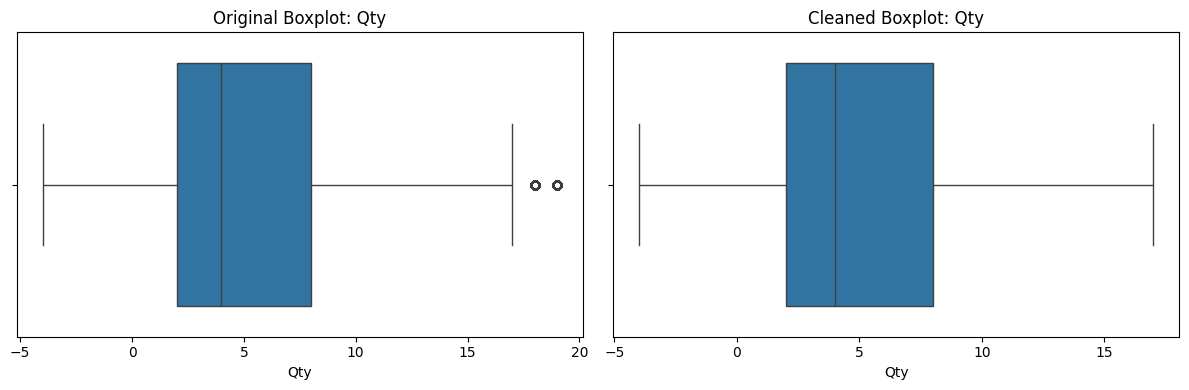

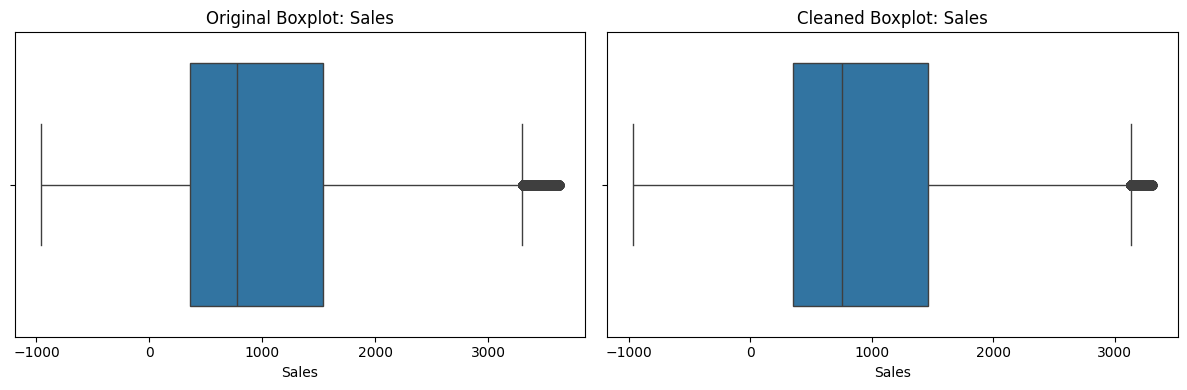

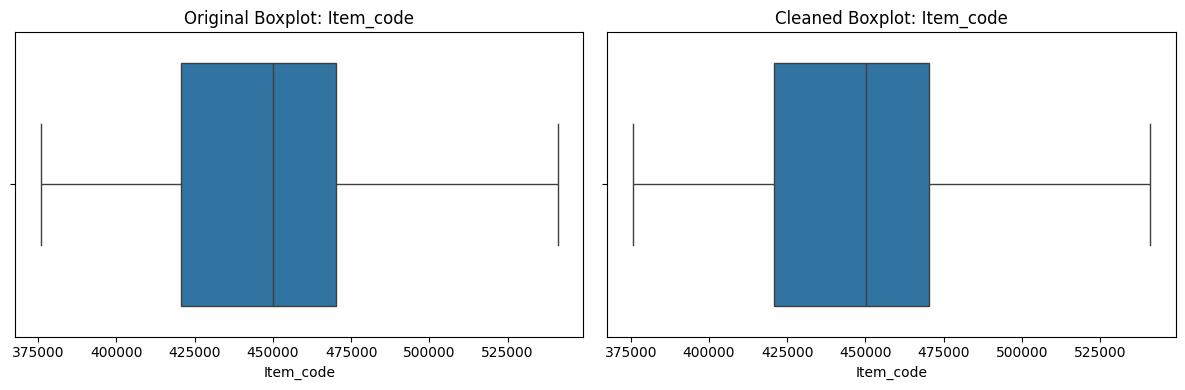

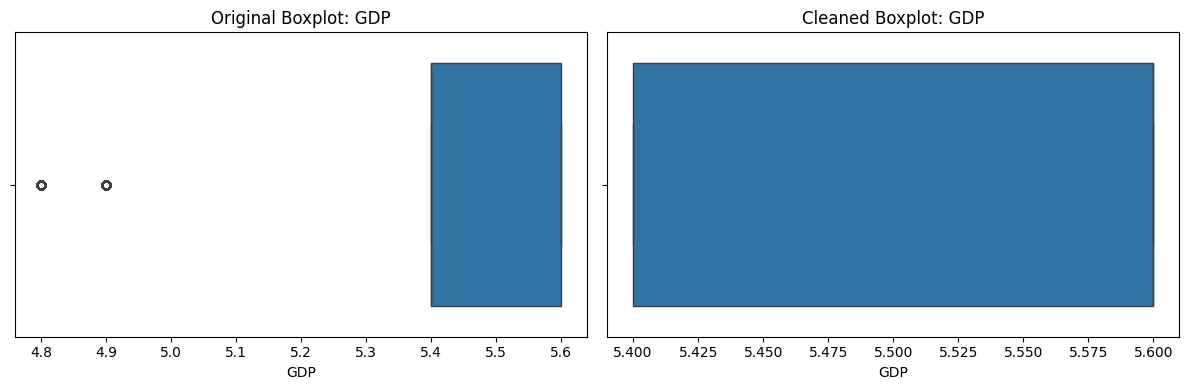

In [16]:
### Handling Outliers in the Data
# Specify the columns to clean
columns_to_clean = ['Qty', 'Sales', 'Item_code',"GDP"]

# Function to remove outliers using IQR
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    cleaned_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return cleaned_data

# Apply outlier removal and visualize
for col in columns_to_clean:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Original Boxplot
    sns.boxplot(x=df[col], ax=axes[0])
    axes[0].set_title(f"Original Boxplot: {col}")

    # Remove outliers
    df = remove_outliers_iqr(df, col)

    # Boxplot after cleaning
    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f"Cleaned Boxplot: {col}")

    plt.tight_layout()
    plt.show()

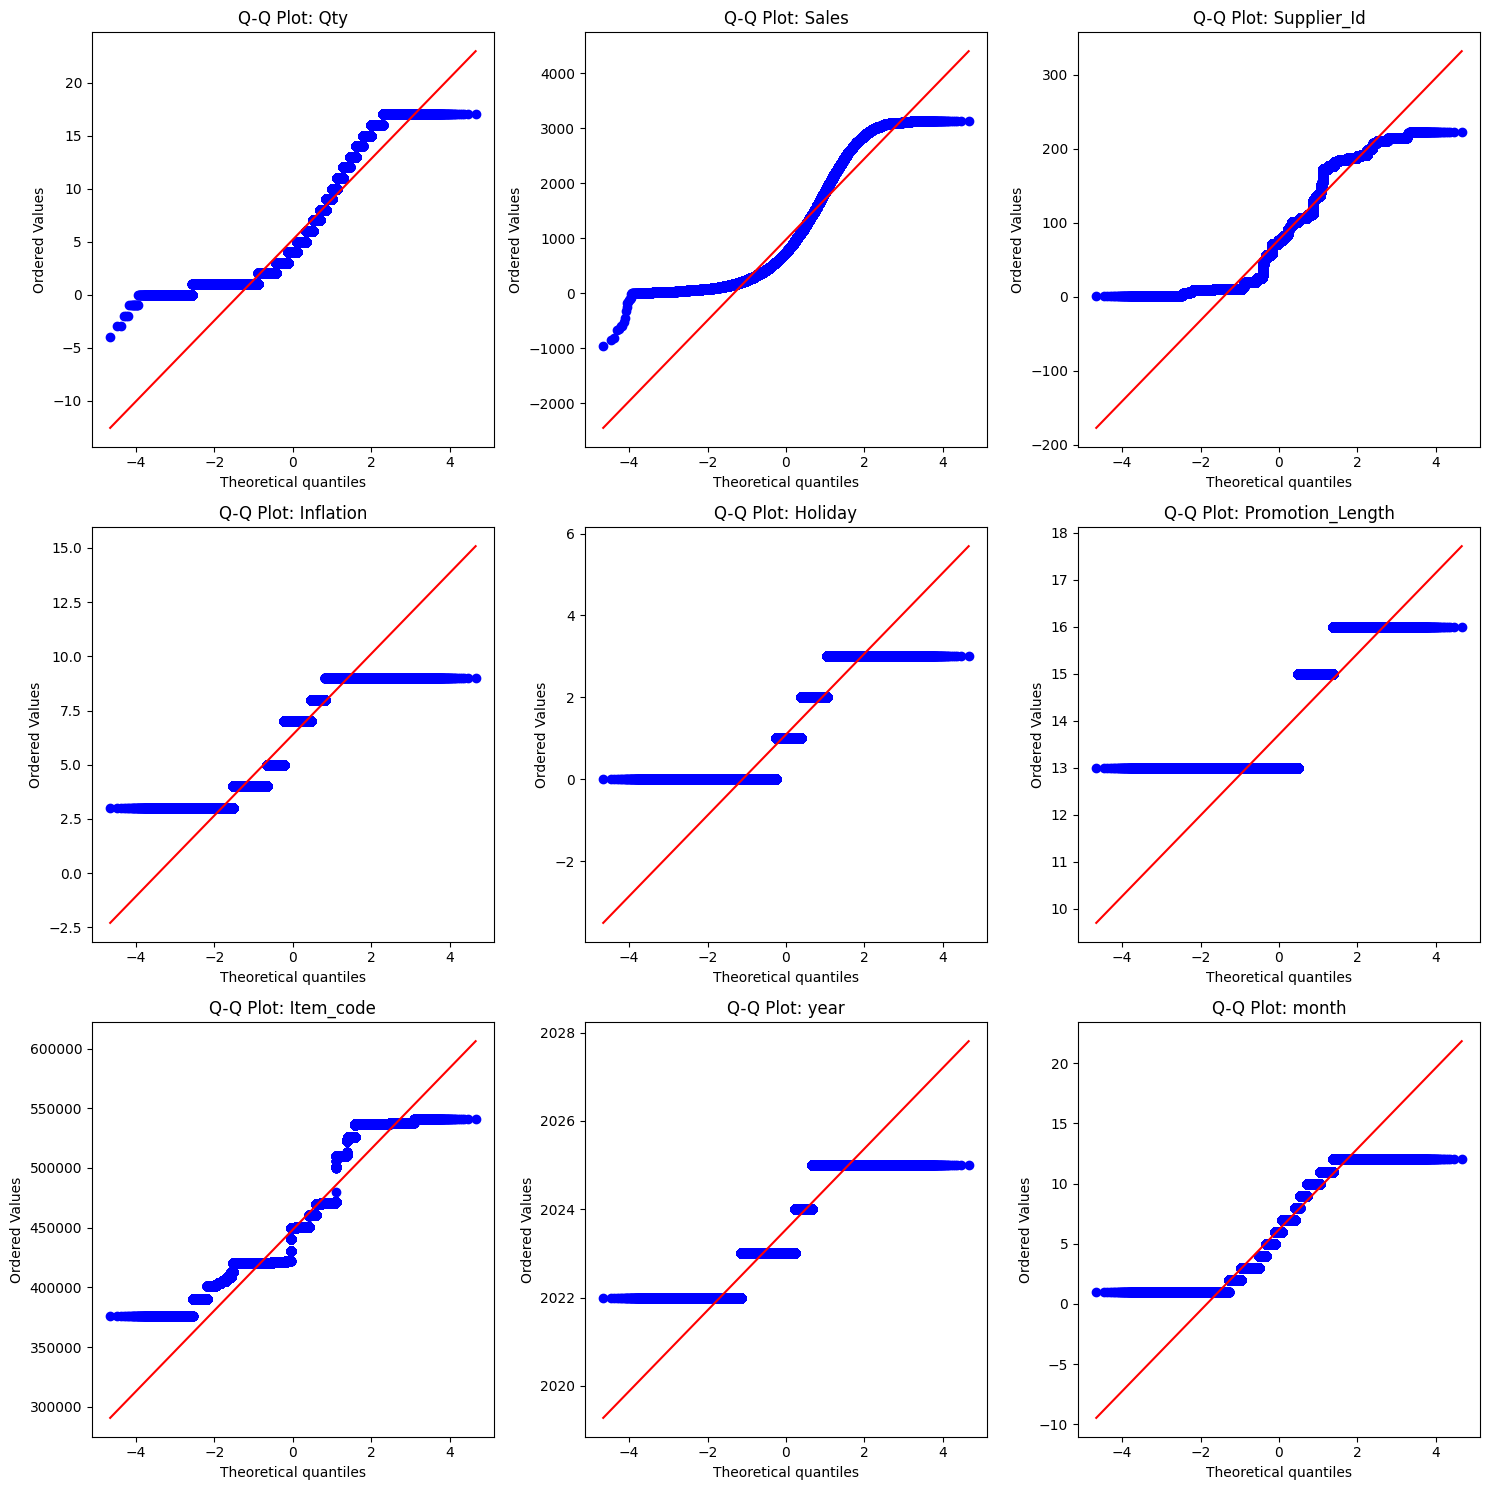

In [ ]:
from scipy.stats import probplot

# Create Q-Q plots for numerical columns
numerical_cols = df.select_dtypes(include=np.number).columns
n_cols = 3
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    probplot(df[col], dist="norm", plot=axes[i])
    axes[i].set_title(f"Q-Q Plot: {col}")

# Hide any unused subplots
for i in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

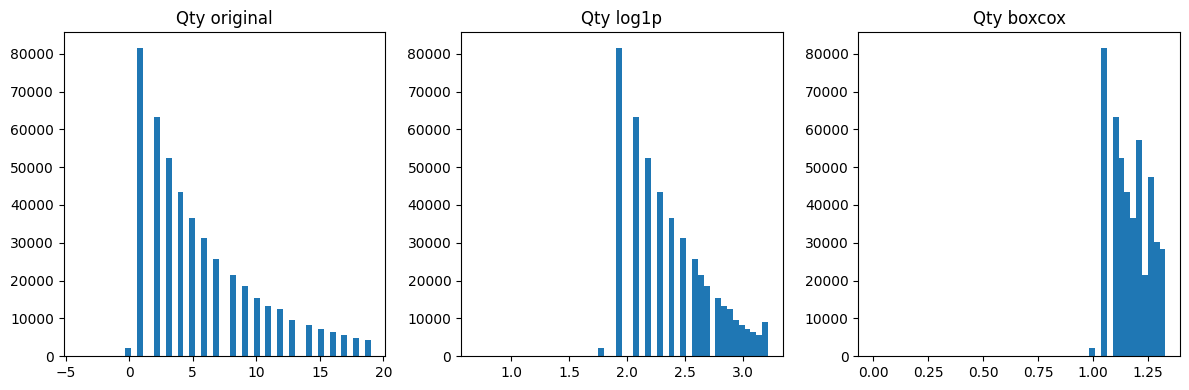

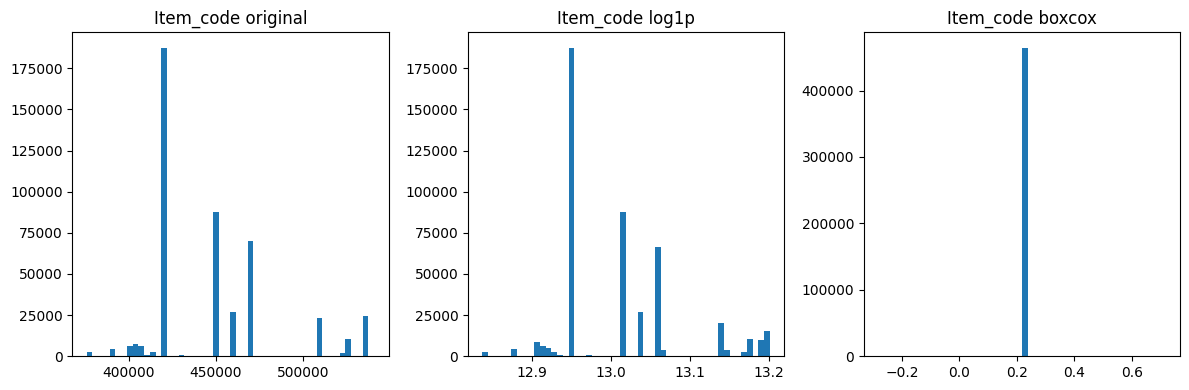

In [ ]:
## transformimg data
from scipy import stats
from sklearn.preprocessing import PowerTransformer

# Example: list of target columns to transform
target_cols = ['Qty', 'Item_code']  # adjust to your data

# Copy dataframe to avoid modifying original
df_transformed = df.copy()

# Helper: apply log transformation safely (shift if needed to handle non-positive values)
def log_safe(series, add_offset=None):
    arr = series.values
    if add_offset is None:
        # find a minimal shift to make all values > 0
        min_val = arr.min()
        offset = 1 - min_val if min_val <= 0 else 0
    else:
        offset = add_offset
    return np.log1p(arr + offset), offset

# Apply log transformation where appropriate
log_offsets = {}
for col in target_cols:
    s = df_transformed[col]
    # Check positivity
    if (s > 0).all():
        # safe log1p
        df_transformed[col + '_log'] = np.log1p(s)
        log_offsets[col] = 0  # no explicit offset needed
    else:
        # shift to positive before log
        transformed, offset = log_safe(s, add_offset=None)
        df_transformed[col + '_log'] = transformed
        log_offsets[col] = offset

# Box-Cox requires strictly positive values. Apply to the same columns using the positive data
boxcox_results = {}
for col in target_cols:
    s = df_transformed[col]
    # Ensure positivity
    if (s <= 0).any():
        # shift to make all values positive
        min_val = s.min()
        shift = 1 - min_val
        s_pos = s + shift
        # Box-Cox requires positive; apply
        transformed, fitted_lambda = stats.boxcox(s_pos)
        df_transformed[col + '_boxcox'] = transformed
        boxcox_results[col] = {'lambda': fitted_lambda, 'shift': shift}
    else:
        transformed, fitted_lambda = stats.boxcox(s)
        df_transformed[col + '_boxcox'] = transformed
        boxcox_results[col] = {'lambda': fitted_lambda, 'shift': 0}

# Optional: Use sklearn's PowerTransformer (Yeo-Johnson automatically handles 0/negative)
# This can be a drop-in way to stabilize variance without manual shifts
pt = PowerTransformer(method='yeo-johnson', standardize=False)
pt_cols = target_cols  # columns to transform
df_pow = pd.DataFrame(pt.fit_transform(df_transformed[pt_cols]), columns=[c + '_pt' for c in pt_cols], index=df_transformed.index)

df_transformed = pd.concat([df_transformed, df_pow], axis=1)

# Summary: you now have:
# - Original columns (unchanged)
# - _log transformed columns
# - _boxcox transformed columns
# - _pt (PowerTransformer) transformed columns

# Example: inspect distributions before/after
import matplotlib.pyplot as plt
for col in target_cols:
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].hist(df_transformed[col], bins=50)
    axes[0].set_title(f'{col} original')

    axes[1].hist(df_transformed[col + '_log'], bins=50)
    axes[1].set_title(f'{col} log1p')

    axes[2].hist(df_transformed[col + '_boxcox'], bins=50)
    axes[2].set_title(f'{col} boxcox')
    plt.tight_layout()
    plt.show()

# Note:
# - Choose the transformation that best stabilizes variance and reduces skew for downstream modeling.
# - For scikit-learn pipelines, you can integrate these as preprocessing steps:
#   - ColumnTransformer with pipelines for each column
#   - Use the same lambda/offsets if you need inverse transforms later

In [ ]:
# Create density plots for numerical columns
numerical_cols = df_transformed.select_dtypes(include=['number']).columns
n_cols = 3
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.kdeplot(data=df_transformed, x=col, ax=axes[i], fill=True)
    axes[i].set_title(f"Density Plot: {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Density")

# Hide any unused subplots
for i in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [17]:
# Always start from a fresh copy of the main dataframe
df_master = df.copy()

#working copy
df_work = df_master.copy()


In [ ]:
df.shape

(440197, 14)

In [18]:
df_master.shape

(361251, 23)

In [ ]:
# Create filtered copies independently from the original dataset
df_Quickmart = df_work.copy()
df_Quickmart = df_Quickmart[df_Quickmart['Storeid'].str.strip() == 'QM003']

df_Naivas = df_work.copy()
df_Naivas = df_Naivas[df_Naivas['Storeid'].str.strip() == 'N001']

df_Carrefour = df_work.copy()
df_Carrefour = df_Carrefour[df_Carrefour['Storeid'].str.strip() == 'C2']

# Verify results
print(f"Shape of Quickmart (QM003): {df_Quickmart.shape}")
print(f"Shape of Naivas (N001): {df_Naivas.shape}")
print(f"Shape of Carrefour (C2): {df_Carrefour.shape}")


Shape of Quickmart (QM003): (464349, 14)
Shape of Naivas (N001): (0, 14)
Shape of Carrefour (C2): (0, 14)


In [ ]:
df_Quickmart

Storeid   County                Department           Category  \
135794    QM003   Nakuru                   Cereals  Breakfast Cereals   
135795    QM003   Nakuru  Spreads & Food Additives    Food Addictives   
135796    QM003   Nakuru  Spreads & Food Additives    Food Addictives   
135797    QM003   Nakuru  Spreads & Food Additives    Food Addictives   
135798    QM003   Nakuru  Spreads & Food Additives    Food Addictives   
...         ...      ...                       ...                ...   
1020688   QM003  Nairobi  Spreads & Food Additives        Spreadables   
1020691   QM003  Nairobi  Spreads & Food Additives        Spreadables   
1020701   QM003    Narok  Spreads & Food Additives        Spreadables   
1020706   QM003    Narok  Spreads & Food Additives        Spreadables   
1020707   QM003    Narok  Spreads & Food Additives        Spreadables   

             Brand  Qty      Sales  Supplier_Id  Inflation  Holiday  \
135794    Weetabix    5  1041.3791            9          9        0   
135795      Alison    1    67.2414          172          9        0   
135796    Top Food    8   482.7584           20          9        0   
135797      Clover    2   220.6896           82          9        0   
135798      Alison    2   134.4828          172          9        0   
...            ...  ...        ...          ...        ...      ...   
1020688   Trufoods   19  2784.4822           71          5        0   
1020691    Premier    2  1084.4825           57          5        0   
1020701  Kellogg'S    3  2831.8965          182          5        0   
1020706      Zenko    1   314.6551           85          5        0   
1020707    Premier    1   185.3448           57          5        0   

         Promotion_Length  Item_code  year  month  
135794                 13   401488.0  2022      9  
135795                 13   403842.0  2022      9  
135796                 13   421541.0  2022      9  
135797                 13   450022.0  2022      9  
135798                 13   450024.0  2022      9  
...                   ...        ...   ...    ...  
1020688                13   450057.0  2024      9  
1020691                13   450824.0  2024      9  
1020701                13   536520.0  2024      9  
1020706                13   450433.0  2024      9  
1020707                13   450828.0  2024      9  

[464349 rows x 14 columns]

In [ ]:
df_copy1.shape

(464349, 14)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder
from feature_engine.encoding import MeanEncoder
from category_encoders import TargetEncoder as CE_TargetEncoder
# Ensure to return a dataframe
from sklearn import set_config
set_config(transform_output='pandas')

In [ ]:
def show_fit_attributes(transformer):
    """List fit attributes as per scikit-learn convention"""
    return [attr for attr in dir(transformer) if not attr.startswith('_') and attr.endswith('_')]

In [ ]:
#Splitting the variables in to train and test data
X = df_Quickmart.drop('Sales', axis=1)
y = df_Quickmart['Sales']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Training Dataset:{X_train.shape}')
print(f'Testing Dataset:{X_test.shape}')

Training Dataset:(371479, 13)
Testing Dataset:(92870, 13)


In [20]:
#Splitting the variables in to train and test data
X = df.drop('Sales', axis=1)
y = df['Sales']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Training Dataset:{X_train.shape}')
print(f'Testing Dataset:{X_test.shape}')

Training Dataset:(289000, 22)
Testing Dataset:(72251, 22)


In [ ]:
cay_cols=df_Quickmart.select_dtypes(include='object').columns
cay_cols

In [ ]:
cay_cols=df.select_dtypes(include='object').columns
cay_cols

Index(['Storeid', 'Store_name', 'County', 'Region', 'Department', 'Category',
       'Sub_category', 'Item_name', 'Brand', 'Supplier'],
      dtype='object')

In [21]:
# For category_encoders library
from category_encoders import TargetEncoder

# 1. Specify columns explicitly if needed
#all_categorical_cols = ['Storeid', 'County', 'Department', 'Category','Brand']
all_categorical_cols = ['Storeid', 'County', 'Department', 'Category','Brand','Store_name','Region','Sub_category','Item_name','Supplier']
categorical_cols = [col for col in all_categorical_cols if col in X_train.columns]

# 2. Create the encoder with correct parameters
encoder = TargetEncoder(cols=categorical_cols, smoothing=10)  # Removed target_type, cv, random_state
# 3. Fit and transform, saving the result
X_train_encoded = encoder.fit_transform(X_train, y_train)
# 4. Also transform test data using the same encoder
X_test_encoded = encoder.transform(X_test)
# 5. Verify the encoding worked
print("Encoded dtypes:", X_train_encoded.dtypes)
#print("Encoded dtypes:", encoded_df.dtypes)

Encoded dtypes: Storeid             float64
Store_name          float64
County              float64
Region              float64
Department          float64
Category            float64
Sub_category        float64
Item_name           float64
Brand               float64
Qty                 float64
Price               float64
Supplier_Id         float64
Supplier            float64
Inflation           float64
CPI                 float64
GDP                 float64
Holiday             float64
Promotion_Length    float64
Promotion           float64
Item_code           float64
year                  int32
month                 int32
dtype: object


In [22]:
# Data exploration (optional but recommended)
print("Training data shape:", X_train_encoded.shape)
print("Testing data shape:", X_test_encoded.shape)
print("\nFirst 5 rows of the training data:")
print(X_train_encoded.head())

Training data shape: (289000, 22)
Testing data shape: (72251, 22)

First 5 rows of the training data:
          Storeid   Store_name       County       Region   Department  \
718114  973.01869   885.787794   998.752444  1001.748243   725.181938   
632392  973.01869   737.711537   737.711537   873.169167  1112.181592   
452803  973.01869   929.547238   929.547238   873.169167   725.181938   
735734  973.01869  1043.171652   998.752444  1001.748243   725.181938   
521229  973.01869  1016.258422  1002.008031   956.468511   725.181938   

           Category  Sub_category    Item_name        Brand  Qty  ...  \
718114   662.977289   1009.453997   737.085478  1042.829493  3.0  ...   
632392  1250.183994   1263.432289  1933.728935  1959.294673  2.0  ...   
452803   957.417667    963.494147  1611.406507  1061.615433  7.0  ...   
735734   662.977289    638.461133   370.785027   488.851382  3.0  ...   
521229   662.977289    678.154838   801.893494   744.628101  2.0  ...   

           Supplier 

In [ ]:
X_train_encoded.head(5)

Storeid       County   Department     Category        Brand   Qty  \
573181  1073.771712  1096.598813   774.410419  1016.755478  1755.661993   2.0   
814279  1073.771712  1122.284852   774.410419   715.888434   887.767906  10.0   
668274  1073.771712  1096.598813  1173.172357  1339.021630   947.987079   1.0   
159571  1073.771712   954.966144  1173.172357  1004.954106   782.636339   4.0   
464514  1073.771712  1096.598813   774.410419   715.888434   603.148255   6.0   

        Supplier_Id  Inflation  Holiday  Promotion_Length  Item_code  year  \
573181        182.0        9.0      0.0              13.0   420792.0  2023   
814279        111.0        4.0      1.0              13.0   421347.0  2025   
668274        211.0        3.0      1.0              15.0   450104.0  2025   
159571         82.0        9.0      0.0              13.0   420616.0  2022   
464514         10.0        7.0      0.0              13.0   421158.0  2023   

        month  
573181      3  
814279      3  
668274      1  
159571      9  
464514      7

#### Feature Engine

In [ ]:
# Instantiate encoder
#encoder = MeanEncoder(smoothing='auto')

# Fit train data
#3encoder.fit(X_train, y_train)

# Transform test data
#encoder.transform(X_test)

In [23]:
#  Data normalization and scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# # # Convert to DataFrame for easier inspection (optional)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("\nScaled training data statistics:")
print(X_train_scaled_df.describe().round(2))



Scaled training data statistics:
        Storeid  Store_name     County     Region  Department   Category  \
count  289000.0   289000.00  289000.00  289000.00   289000.00  289000.00   
mean        0.0       -0.00       0.00       0.00       -0.00       0.00   
std         0.0        1.00       1.00       1.00        1.00       1.00   
min         0.0       -2.52      -3.70      -3.47       -0.85      -1.24   
25%         0.0       -0.65      -0.29      -0.28       -0.85      -0.95   
50%         0.0       -0.01       0.40       0.49       -0.85      -0.30   
75%         0.0        0.66       0.40       0.49        0.78       0.85   
max         0.0        2.46       1.38       1.68        1.82       2.26   

       Sub_category  Item_name      Brand        Qty  ...   Supplier  \
count     289000.00  289000.00  289000.00  289000.00  ...  289000.00   
mean          -0.00      -0.00      -0.00      -0.00  ...       0.00   
std            1.00       1.00       1.00       1.00  ...       1

In [ ]:
X_train_encoded

Storeid       County   Department     Category        Brand   Qty  \
573181  1073.771712  1096.598813   774.410419  1016.755478  1755.661993   2.0   
814279  1073.771712  1122.284852   774.410419   715.888434   887.767906  10.0   
668274  1073.771712  1096.598813  1173.172357  1339.021630   947.987079   1.0   
159571  1073.771712   954.966144  1173.172357  1004.954106   782.636339   4.0   
464514  1073.771712  1096.598813   774.410419   715.888434   603.148255   6.0   
...             ...          ...          ...          ...          ...   ...   
620169  1073.771712  1096.598813  1173.172357  1339.021630  1223.493326   4.0   
830853  1073.771712  1170.422064  1475.892909  1475.892909  1444.070897   3.0   
393418  1073.771712  1012.727797   774.410419   715.888434   786.492519   1.0   
420419  1073.771712  1096.598813  1607.868939  1499.019014  1428.189041  10.0   
375263  1073.771712  1096.598813   774.410419   715.888434   408.249166   1.0   

        Supplier_Id  Inflation  Holiday  Promotion_Length  Item_code  year  \
573181        182.0        9.0      0.0              13.0   420792.0  2023   
814279        111.0        4.0      1.0              13.0   421347.0  2025   
668274        211.0        3.0      1.0              15.0   450104.0  2025   
159571         82.0        9.0      0.0              13.0   420616.0  2022   
464514         10.0        7.0      0.0              13.0   421158.0  2023   
...             ...        ...      ...               ...        ...   ...   
620169        177.0        9.0      2.0              15.0   450235.0  2023   
830853        136.0        4.0      3.0              15.0   470605.0  2025   
393418         25.0        7.0      2.0              13.0   420824.0  2023   
420419        107.0        7.0      0.0              13.0   460378.0  2023   
375263        132.0        7.0      2.0              13.0   420689.0  2023   

        month  
573181      3  
814279      3  
668274      1  
159571      9  
464514      7  
...       ...  
620169      1  
830853      4  
393418     10  
420419      7  
375263     10  

[371479 rows x 13 columns]

In [24]:
# Data Normalization Strategy
def normalize_data(X_train_encoded, X_test_encoded):
    """
    Normalize data using StandardScaler with additional validation and handling.

    Args:
        X_train_encoded (array-like): Encoded training features
        X_test_encoded (array-like): Encoded test features

    Returns:
        tuple: Normalized training and test features
    """
    # Check for non-numeric columns
    if not np.all(np.isfinite(X_train_encoded)):
        raise ValueError("Input contains non-numeric or infinite values. Preprocess data first.")

    # Initialize StandardScaler
    scaler = StandardScaler()

    # Fit scaler on training data and transform both train and test sets
    X_train_scaled = scaler.fit_transform(X_train_encoded)
    X_test_scaled = scaler.transform(X_test_encoded)

    # Optional: Convert to DataFrame for easier inspection and tracking
    # Preserve original column names if possible
    try:
        X_train_scaled_df = pd.DataFrame(
            X_train_scaled,
            columns=X_train_encoded.columns if hasattr(X_train_encoded, 'columns') else None
        )
        X_test_scaled_df = pd.DataFrame(
            X_test_scaled,
            columns=X_test_encoded.columns if hasattr(X_test_encoded, 'columns') else None
        )
    except Exception as e:
        print(f"Could not create DataFrame: {e}")
        X_train_scaled_df = X_train_scaled
        X_test_scaled_df = X_test_scaled

    # Comprehensive scaling statistics
    print("\nScaling Report:")
    print("Training Data Statistics:")
    print(pd.DataFrame(X_train_scaled).describe().round(3))

    print("\nTest Data Statistics:")
    print(pd.DataFrame(X_test_scaled).describe().round(3))

    # Verification of scaling
    print("\nVerification:")
    print(f"Mean of training data after scaling: {np.mean(X_train_scaled):.4f}")
    print(f"Standard deviation of training data after scaling: {np.std(X_train_scaled):.4f}")

    return X_train_scaled, X_test_scaled

# Usage example
try:
    X_train_scaled, X_test_scaled = normalize_data(X_train_encoded, X_test_encoded)
except Exception as e:
    print(f"Normalization failed: {e}")


Scaling Report:
Training Data Statistics:
        Storeid  Store_name      County      Region  Department    Category  \
count  289000.0  289000.000  289000.000  289000.000  289000.000  289000.000   
mean        0.0      -0.000       0.000       0.000      -0.000       0.000   
std         0.0       1.000       1.000       1.000       1.000       1.000   
min         0.0      -2.519      -3.702      -3.473      -0.855      -1.236   
25%         0.0      -0.646      -0.291      -0.281      -0.855      -0.949   
50%         0.0      -0.011       0.405       0.489      -0.855      -0.297   
75%         0.0       0.663       0.405       0.489       0.783       0.848   
max         0.0       2.458       1.381       1.676       1.823       2.256   

       Sub_category   Item_name       Brand         Qty  ...    Supplier  \
count    289000.000  289000.000  289000.000  289000.000  ...  289000.000   
mean         -0.000      -0.000      -0.000      -0.000  ...       0.000   
std           1.0

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [ ]:
X_train_scaled.head(5)

Storeid    County  Department  Category     Brand       Qty  \
573181  4.547474e-13  0.348834   -0.960357 -0.163681  1.628953 -0.798510   
814279  4.547474e-13  0.741358   -0.960357 -1.027405 -0.444531  0.981499   
668274  4.547474e-13  0.348834    0.318879  0.761475 -0.300661 -1.021012   
159571  4.547474e-13 -1.815537    0.318879 -0.197561 -0.695700 -0.353508   
464514  4.547474e-13  0.348834   -0.960357 -1.027405 -1.124515  0.091494   

        Supplier_Id  Inflation   Holiday  Promotion_Length  Item_code  \
573181     1.827698   1.309072 -1.001434         -0.654688  -0.768963   
814279     0.583475  -1.214031 -0.082844         -0.654688  -0.753711   
668274     2.335902  -1.718651 -0.082844          1.199841   0.036549   
159571     0.075272   1.309072 -1.001434         -0.654688  -0.773799   
464514    -1.186475   0.299831 -1.001434         -0.654688  -0.758905   

            year     month  
573181 -0.532613 -0.916940  
814279  1.456676 -0.916940  
668274  1.456676 -1.493219  
159571 -1.527258  0.811898  
464514 -0.532613  0.235618

In [ ]:
x_skew=X_train_scaled.skew()
print(x_skew)

Storeid             0.000000
County             -1.560274
Department          0.387481
Category            0.350633
Brand               0.037288
Qty                 1.080656
Supplier_Id         0.504430
Inflation          -0.179435
Holiday             0.508510
Promotion_Length    1.001375
Item_code           0.972103
year                0.283145
month               0.150458
dtype: float64


In [25]:
from sklearn.feature_selection import SelectKBest, f_classif, f_regression

# Feature selection (select top k features)
selector = SelectKBest(score_func=f_regression, k='all')
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

In [ ]:
X_train_selected.head(5)

Storeid    County  Department  Category     Brand       Qty  \
362919  1.136868e-13  1.291651    1.717241  1.225721  0.866947 -1.032794   
343329  1.136868e-13  0.372479    1.717241  1.225721  0.866947  0.690303   
799765  1.136868e-13  0.372479   -0.938855 -1.008746  1.576998  2.413400   
681360  1.136868e-13  1.296932   -0.938855 -0.104960 -0.188550 -0.786637   
763769  1.136868e-13  0.372479   -0.938855 -1.008746 -1.353176 -1.032794   

        Supplier_Id  Inflation   Holiday  Promotion_Length  Item_code  \
362919     0.519184   0.306819  0.834575         -0.654688   0.322661   
343329     0.519184   0.306819  0.834575         -0.654688   0.334522   
799765     1.833321  -1.208093 -0.083632         -0.654688  -0.758039   
681360    -0.006471  -1.713064 -0.083632          1.199877  -0.747955   
763769    -0.006471  -1.208093 -1.001838         -0.654688  -0.772196   

            year     month  
362919 -0.539669  1.099658  
343329 -0.539669  1.099658  
799765  1.451460 -0.916838  
681360  1.451460 -1.492980  
763769  1.451460 -1.204909

In [26]:
from sklearn.ensemble import RandomForestRegressor

In [27]:
# Train Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_selected, y_train)

RandomForestRegressor(random_state=42)

In [28]:
# Evaluate the model
y_pred = rf.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error: 218.66
R² Score: 1.00


In [ ]:
## Model Perfomance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import explained_variance_score, median_absolute_error

y_pred = rf.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)

# Print all metrics
print("Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Median Absolute Error: {median_ae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Explained Variance Score: {explained_var:.4f}")


Model Performance Metrics:
Mean Squared Error (MSE): 19313.7574
Root Mean Squared Error (RMSE): 138.9739
Mean Absolute Error (MAE): 46.5868
Median Absolute Error: 4.3468
R² Score: 0.9679
Explained Variance Score: 0.9679


In [ ]:
#  Feature importance analysis
feature_importances = pd.DataFrame(
    {'feature': X_train_selected.columns, 'importance':rf.feature_importances_}
)
feature_importances = feature_importances.sort_values('importance', ascending=False)
print("Top 10 features:")
print(feature_importances.head(10))

Top 10 features:
        feature  importance
5           Qty    0.344237
10    Item_code    0.294408
4         Brand    0.262298
6   Supplier_Id    0.031027
3      Category    0.022404
2    Department    0.017377
1        County    0.007615
7     Inflation    0.006497
12        month    0.005146
11         year    0.004917


In [ ]:
# Cross-validation score
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(rf, X_train_selected, y_train, cv=5, scoring='r2')
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Average CV R² Score: {cv_scores.mean():.2f}")

Cross-Validation R² Scores: [0.96482569 0.96265012 0.96309906 0.96464753 0.96433099]
Average CV R² Score: 0.96


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train_selected, y_train)

GradientBoostingRegressor(random_state=42)

In [ ]:
# Evaluate the model
y_pred = gb.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
r2= r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)

# Print all metrics
print("Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Median Absolute Error: {median_ae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Explained Variance Score: {explained_var:.4f}")
print(f"Test MSE: {mse:.3f}")
print(f"Test R²: {r2:.3f}")

Mean Squared Error: 224730.25
R² Score: 0.63
Model Performance Metrics:
Mean Squared Error (MSE): 224730.2502
Root Mean Squared Error (RMSE): 474.0572
Mean Absolute Error (MAE): 343.2284
Median Absolute Error: 244.9799
R² Score: 0.6259
Explained Variance Score: 0.6259
Test MSE: 224730.250
Test R²: 0.626


In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr = LinearRegression()
lr.fit(X_train_selected, y_train)

LinearRegression()

In [ ]:
# Evaluate the model
y_pred = lr.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
r2= r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)

# Print all metrics
print("Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Median Absolute Error: {median_ae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Explained Variance Score: {explained_var:.4f}")
print(f"Test MSE: {mse:.3f}")
print(f"Test R²: {r2:.3f}")

Mean Squared Error: 291756.51
R² Score: 0.51
Model Performance Metrics:
Mean Squared Error (MSE): 291756.5113
Root Mean Squared Error (RMSE): 540.1449
Mean Absolute Error (MAE): 401.4737
Median Absolute Error: 304.7325
R² Score: 0.5144
Explained Variance Score: 0.5144
Test MSE: 291756.511
Test R²: 0.514


In [ ]:
from sklearn.svm import SVR

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
dt = DecisionTreeRegressor(max_depth=5, random_state=42)

In [ ]:
dt.fit(X_train_selected, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [ ]:
dt.fit(X_train_selected, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [ ]:
#model evaluation
y_pred = dt.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
r2= r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)

# Print all metrics
print("Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Median Absolute Error: {median_ae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Explained Variance Score: {explained_var:.4f}")
print(f"Test MSE: {mse:.3f}")
print(f"Test R²: {r2:.3f}")

Mean Squared Error: 261217.39
R² Score: 0.57
Model Performance Metrics:
Mean Squared Error (MSE): 261217.3866
Root Mean Squared Error (RMSE): 511.0943
Mean Absolute Error (MAE): 372.7788
Median Absolute Error: 266.1625
R² Score: 0.5652
Explained Variance Score: 0.5652
Test MSE: 261217.387
Test R²: 0.565


In [ ]:
#  Feature importance analysis
feature_importances = pd.DataFrame(
    {'feature': X_train_selected.columns, 'importance': gb.feature_importances_}
)
feature_importances = feature_importances.sort_values('importance', ascending=False)
print("Top 10 features:")
print(feature_importances.head(10))

Top 10 features:
        feature  importance
5           Qty    0.516593
4         Brand    0.306455
3      Category    0.082835
10    Item_code    0.047088
2    Department    0.025088
6   Supplier_Id    0.018609
1        County    0.002550
7     Inflation    0.000403
11         year    0.000378
0       Storeid    0.000000


In [ ]:
#  Feature importance analysis
feature_importances = pd.DataFrame(
    {'feature': X_train_selected.columns, 'importance': dt.feature_importances_}
)
feature_importances = feature_importances.sort_values('importance', ascending=False)
print("Top 10 features:")
print(feature_importances.head(10))

Top 10 features:
        feature  importance
5           Qty    0.538000
4         Brand    0.400822
10    Item_code    0.028724
2    Department    0.018647
3      Category    0.011226
6   Supplier_Id    0.002581
0       Storeid    0.000000
1        County    0.000000
7     Inflation    0.000000
8       Holiday    0.000000


In [ ]:
# Train Random Forest Regressor
#rf = RandomForestRegressor(random_state=42)
#rf.fit(X_train_selected, y_train)

In [29]:
# Hyperparameter tuning using RandomizedSearchCV
#  Define hyperparameter search space (with distributions for RandomizedSearchCV)
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'n_estimators': np.arange(100, 500, 50),
    'max_depth': [None] + list(np.arange(10, 50, 10)),
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Set up RandomizedSearchCV with cross-validation
rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=20,  # Number of parameter settings sampled
    cv=5,       # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,  # Use all available cores
    random_state=42
)

#  Perform hyperparameter tuning
random_search.fit(X_train_selected, y_train)

# 4. Get best parameters and best score
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score: {:.3f}".format(-random_search.best_score_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# 5. Train final model with best parameters
best_rf = RandomForestRegressor(
    **random_search.best_params_,
    random_state=42
)
best_rf.fit(X_train_selected, y_train)

RandomForestRegressor(max_depth=np.int64(40), max_features='sqrt',
                      min_samples_split=5, n_estimators=np.int64(150),
                      random_state=42)

In [ ]:
# Evaluate the model, Calculate metrics
y_pred = best_rf.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)

# Print all metrics
print("Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Median Absolute Error: {median_ae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Explained Variance Score: {explained_var:.4f}")
print(f"Test MSE: {mse:.3f}")
print(f"Test R²: {r2:.3f}")

Model Performance Metrics:
Mean Squared Error (MSE): 73530.8026
Root Mean Squared Error (RMSE): 271.1656
Mean Absolute Error (MAE): 163.9922
Median Absolute Error: 84.5971
R² Score: 0.8776
Explained Variance Score: 0.8776
Test MSE: 73530.803
Test R²: 0.878


In [30]:
from sklearn.ensemble import RandomForestRegressor

def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 4, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    # Create the Random Forest Regressor with the suggested hyperparameters
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )

    # Train the model on TRAINING data
    rf.fit(X_train_selected, y_train)

    # Make predictions on the TEST set
    y_pred = rf.predict(X_test_selected)

    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)

    # Report intermediate results for pruning
    trial.report(mse, step=0)

    # Handle pruning based on the intermediate value
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return mse

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100) # Reduced n_trials for faster execution

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

[I 2025-11-20 12:22:36,994] A new study created in memory with name: no-name-224f6ede-6333-4587-8af2-85f98124e021
[I 2025-11-20 12:23:04,942] Trial 0 finished with value: 31351.410682321766 and parameters: {'n_estimators': 69, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 0 with value: 31351.410682321766.
[I 2025-11-20 12:25:05,501] Trial 1 finished with value: 46827.399413123436 and parameters: {'n_estimators': 343, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 0 with value: 31351.410682321766.
[I 2025-11-20 12:25:39,570] Trial 2 finished with value: 34675.63865411567 and parameters: {'n_estimators': 88, 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 31351.410682321766.
[I 2025-11-20 12:27:41,724] Trial 3 finished with value: 36338.556604222336 and parameters: {'n_estimators': 325, 'max_depth': 15, 'm

Best hyperparameters:  {'n_estimators': 354, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}


In [ ]:
from sklearn.ensemble import RandomForestRegressor

def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 4, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    # Create the Random Forest Regressor with the suggested hyperparameters
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )



    # Train the model
    rf.fit(X_test_selected, y_train)

    # Make predictions on the test set
    y_pred = rf.predict(X_test_selected)

    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)

    # Report intermediate results for pruning
    trial.report(mse, step=0)

    # Handle pruning based on the intermediate value
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return mse

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=50) # Reduced n_trials for faster execution

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

In [31]:
study.best_params


{'n_estimators': 354,
 'max_depth': 29,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2'}

In [32]:
best_params = study.best_params

In [33]:

from optuna.visualization import plot_optimization_history # Corrected import

plot_optimization_history(study)

In [34]:
optuna.visualization.plot_parallel_coordinate(study)

In [35]:
optuna.visualization.plot_slice(study, params=['n_estimators','max_depth', 'min_samples_split','min_samples_leaf'])

In [36]:
optuna.visualization.plot_param_importances(study)

In [37]:
best_n_estimators = best_params['n_estimators']
best_max_depth = best_params['max_depth']
best_min_samples_split = best_params['min_samples_split']
best_min_samples_leaf = best_params['min_samples_leaf']

In [38]:
best_model = RandomForestRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf
)

In [39]:
best_model.fit(X_train_selected, y_train)

RandomForestRegressor(max_depth=29, n_estimators=354)

In [40]:
y_pred = best_model.predict(X_test_selected)

In [41]:
mean_squared_error(y_test, y_pred)

217.85736601182995

In [42]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred)

0.8491432455070236

In [43]:
r2_score(y_test, y_pred)

0.9996598358424779

In [44]:
# Evaluate the model, Calculate metrics
# Import necessary metrics from scikit-learn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import explained_variance_score, median_absolute_error
import numpy as np

# Evaluate the model, Calculate metrics
y_pred = best_model.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)

# Print all metrics
print("Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Median Absolute Error: {median_ae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Explained Variance Score: {explained_var:.4f}")
print(f"Test MSE: {mse:.3f}")
print(f"Test R²: {r2:.3f}")

Model Performance Metrics:
Mean Squared Error (MSE): 217.8574
Root Mean Squared Error (RMSE): 14.7600
Mean Absolute Error (MAE): 0.8491
Median Absolute Error: 0.0000
R² Score: 0.9997
Explained Variance Score: 0.9997
Test MSE: 217.857
Test R²: 1.000


In [ ]:
# R² Scores
r2_scores = cross_val_score(best_model, X_train_selected, y_train, cv=5, scoring='r2')
print("Cross-Validation R² Scores:", r2_scores)
print("Average R² Score:", r2_scores.mean())

# MSE (note: scoring returns NEGATIVE MSE, so we negate it back)
neg_mse_scores = cross_val_score(best_model, X_train_selected, y_train, cv=5, scoring='neg_mean_squared_error')
mse_scores = -neg_mse_scores
print("Cross-Validation MSE Scores:", mse_scores)
print("Average MSE:", mse_scores.mean())

# MAE
neg_mae_scores = cross_val_score(best_model, X_train_selected, y_train, cv=5, scoring='neg_mean_absolute_error')
mae_scores = -neg_mae_scores
print("Cross-Validation MAE Scores:", mae_scores)
print("Average MAE:", mae_scores.mean())


Cross-Validation R² Scores: [0.99999532 0.99998211 0.99999482 0.99994133 0.9999788 ]
Average R² Score: 0.9999784765960944
Cross-Validation MSE Scores: [ 3.35115503 12.43069049  3.69231511 43.09736419 15.52101098]
Average MSE: 15.61850715769442
Cross-Validation MAE Scores: [0.27593903 0.31034662 0.27403365 0.32174441 0.29531118]
Average MAE: 0.2954749764219239


**bold text**

In [ ]:
# Hyperparameter tuning using RandomizedSearchCV
#  Define hyperparameter search space (with distributions for RandomizedSearchCV)
from scipy.stats import randint, uniform

param_dist = {
    'n_estimators': randint(50, 100),         # More trees for stability
    'max_depth': randint(5, 10,15),                # Deep trees help capture complexity
    'min_samples_split': randint(2,5,10),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}


In [ ]:
# Cross-validation score
cv_scores = cross_val_score(best_rf, X_train_selected, y_train, cv=5, scoring='r2')
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Average CV R² Score: {cv_scores.mean():.2f}")


In [ ]:
# Evaluate the model, Calculate metrics
y_pred = best_rf.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)

# Print all metrics
print("Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Median Absolute Error: {median_ae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Explained Variance Score: {explained_var:.4f}")
print(f"Test MSE: {mse:.3f}")
print(f"Test R²: {r2:.3f}")

In [ ]:

# R² Scores
r2_scores = cross_val_score(best_rf, X_train_selected, y_train, cv=5, scoring='r2')
print("Cross-Validation R² Scores:", r2_scores)
print("Average R² Score:", r2_scores.mean())

# MSE (note: scoring returns NEGATIVE MSE, so we negate it back)
neg_mse_scores = cross_val_score(best_rf, X_train_selected, y_train, cv=5, scoring='neg_mean_squared_error')
mse_scores = -neg_mse_scores
print("Cross-Validation MSE Scores:", mse_scores)
print("Average MSE:", mse_scores.mean())

# MAE
neg_mae_scores = cross_val_score(best_rf, X_train_selected, y_train, cv=5, scoring='neg_mean_absolute_error')
mae_scores = -neg_mae_scores
print("Cross-Validation MAE Scores:", mae_scores)
print("Average MAE:", mae_scores.mean())


In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([r2_scores, mse_scores, mae_scores], labels=["R²", "MSE", "MAE"])
plt.title("Cross-Validation Score Distribution")
plt.ylabel("Score Value")
plt.grid(True)
plt.show()


In [ ]:
#  Feature importance analysis
feature_importances = pd.DataFrame(
    {'feature': X_train_selected.columns, 'importance': best_model.feature_importances_}
)
feature_importances = feature_importances.sort_values('importance', ascending=False)
print("Top 10 features:")
print(feature_importances.head(10))

# Visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20)) # Display top 20 features
plt.title('Feature Importances from Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

NameError: name 'best_rf' is not defined

In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
# Create sample data for demonstration
# In a real scenario, you would use your actual model predictions
np.random.seed(42)
y_test = np.random.randint(0, 2, 100)  # Generate random binary labels (0 or 1)
y_proba = np.random.random(100)  # Generate random probabilities between 0 and 1

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
# Create a scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()

In [ ]:
# Create residual plot
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.grid(True)
plt.tight_layout()

In [ ]:
# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7)
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.tight_layout()

NameError: name 'residuals' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Plot prediction error as percentage - with protection against division by zero
plt.figure(figsize=(10, 6))
# Add a small epsilon to prevent division by zero
epsilon = 1e-10
# Use np.where to handle cases where y_test is zero or close to zero
percentage_error = np.where(np.abs(y_test) > epsilon,
                           np.abs(residuals / y_test) * 100,
                           0)  # Set to 0% error where y_test is close to zero
# Filter out any infinite values that might still occur
percentage_error = percentage_error[np.isfinite(percentage_error)]
plt.hist(percentage_error, bins=30, alpha=0.7)
plt.xlabel('Percentage Error (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage Errors')
plt.grid(True)
plt.tight_layout()

plt.show()

In [ ]:
# Save the model
joblib.dump(best_model, 'random_forest_model.pkl')
print("Model saved as 'random_forest_model.pkl'")
# Save the trained model to disk
def save_model(model, filename='random_forest_model.pkl'):
    """Save the trained model to disk"""
    joblib.dump(model, filename)
    print(f"Model saved as {filename}")

    # Also save feature names for future reference
    if hasattr(model, 'feature_importances_'):
        feature_names = pd.DataFrame({
            'feature': X_train_selected.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        feature_names.to_csv('feature_importance.csv', index=False)
        print("Feature importance saved to feature_importance.csv")

# Save your best model
save_model(best_rf)

## 1. Data Validation with Pydantic

In [ ]:
from pydantic import BaseModel, validator, Field
from typing import List, Optional, Dict, Any
import numpy as np
import pandas as pd

class PredictionInput(BaseModel):
    """Validate input data for predictions"""

    # Define expected features and their types
    # Modify these according to your actual features
    feature1: float
    feature2: float
    feature3: Optional[float] = None
    feature4: str

    # Add validators for specific features
    @validator('feature1')
    def feature1_must_be_positive(cls, v):
        if v < 0:
            raise ValueError('feature1 must be positive')
        return v

    @validator('feature4')
    def feature4_must_be_valid_category(cls, v):
        valid_categories = ['A', 'B', 'C']  # Replace with your valid categories
        if v not in valid_categories:
            raise ValueError(f'feature4 must be one of {valid_categories}')
        return v

    # Convert to DataFrame for prediction
    def to_dataframe(self) -> pd.DataFrame:
        return pd.DataFrame([self.dict()])

class BatchPredictionInput(BaseModel):
    """Validate batch input data"""
    inputs: List[Dict[str, Any]]

    def to_dataframe(self) -> pd.DataFrame:
        return pd.DataFrame(self.inputs)

#### 2. Logging System

In [ ]:
import logging
import time
from datetime import datetime
import uuid

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("model_predictions.log"),
        logging.StreamHandler()
    ]
)

logger = logging.getLogger("model_service")

class PredictionLogger:
    def __init__(self, model_version):
        self.model_version = model_version

    def log_prediction(self, input_data, prediction, prediction_id=None):
        """Log a single prediction"""
        if prediction_id is None:
            prediction_id = str(uuid.uuid4())

        logger.info(
            f"Prediction ID: {prediction_id} | "
            f"Model Version: {self.model_version} | "
            f"Input Shape: {input_data.shape} | "
            f"Prediction: {prediction[:5]}... | "
            f"Timestamp: {datetime.now().isoformat()}"
        )
        return prediction_id

    def log_error(self, error_msg, input_data=None):
        """Log prediction errors"""
        error_id = str(uuid.uuid4())
        input_info = f"Input Shape: {input_data.shape}" if input_data is not None else "No input data"

        logger.error(
            f"Error ID: {error_id} | "
            f"Model Version: {self.model_version} | "
            f"{input_info} | "
            f"Error: {error_msg} | "
            f"Timestamp: {datetime.now().isoformat()}"
        )
        return error_id

## 3. FastAPI Endpoint for Model Serving

In [ ]:
from fastapi import FastAPI, HTTPException, BackgroundTasks, Depends
from fastapi.responses import JSONResponse
import joblib
import pandas as pd
import numpy as np
import time
import os

app = FastAPI(title="ML Model API", description="API for Random Forest Regression Model", version="1.0.0")

# Load model at startup
MODEL_PATH = "random_forest_model.pkl"
model = None

# Initialize logger
prediction_logger = None

@app.on_event("startup")
async def startup_event():
    global model, prediction_logger
    model = joblib.load(MODEL_PATH)
    model_version = os.environ.get("MODEL_VERSION", "1.0.0")
    prediction_logger = PredictionLogger(model_version)
    logger.info(f"Model loaded successfully. Version: {model_version}")

def get_model():
    """Dependency to get the model"""
    if model is None:
        raise HTTPException(status_code=503, detail="Model not loaded")
    return model

@app.post("/predict/")
async def predict(
    input_data: PredictionInput,
    background_tasks: BackgroundTasks,
    model=Depends(get_model)
):
    """Make a single prediction"""
    try:
        # Convert to DataFrame
        df = input_data.to_dataframe()

        # Make prediction
        start_time = time.time()
        prediction = make_predictions(model, df)
        prediction_time = time.time() - start_time

        # Log prediction asynchronously
        prediction_id = str(uuid.uuid4())
        background_tasks.add_task(
            prediction_logger.log_prediction,
            df, prediction, prediction_id
        )

        return {
            "prediction_id": prediction_id,
            "prediction": float(prediction[0]),
            "model_version": prediction_logger.model_version,
            "prediction_time_ms": round(prediction_time * 1000, 2)
        }

    except Exception as e:
        error_id = prediction_logger.log_error(str(e), df if 'df' in locals() else None)
        raise HTTPException(status_code=400, detail=f"Prediction error: {str(e)}. Error ID: {error_id}")

@app.post("/predict/batch/")
async def predict_batch(
    batch_input: BatchPredictionInput,
    background_tasks: BackgroundTasks,
    model=Depends(get_model)
):
    """Make batch predictions"""
    try:
        # Convert to DataFrame
        df = batch_input.to_dataframe()

        # Make predictions
        start_time = time.time()
        predictions = make_predictions(model, df)
        prediction_time = time.time() - start_time

        # Log prediction asynchronously
        prediction_id = str(uuid.uuid4())
        background_tasks.add_task(
            prediction_logger.log_prediction,
            df, predictions, prediction_id
        )

        return {
            "prediction_id": prediction_id,
            "predictions": predictions.tolist(),
            "count": len(predictions),
            "model_version": prediction_logger.model_version,
            "prediction_time_ms": round(prediction_time * 1000, 2)
        }

    except Exception as e:
        error_id = prediction_logger.log_error(str(e), df if 'df' in locals() else None)
        raise HTTPException(status_code=400, detail=f"Batch prediction error: {str(e)}. Error ID: {error_id}")

# Health check endpoint
@app.get("/health/")
async def health_check():
    if model is None:
        raise HTTPException(status_code=503, detail="Model not loaded")
    return {"status": "healthy", "model_version": prediction_logger.model_version}

##### Model driff Monitoring

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

class ModelMonitor:
    def __init__(self, reference_data, model, feature_names):
        """
        Initialize model monitor with reference data

        Parameters:
        - reference_data: DataFrame with the training data distribution
        - model: The trained model
        - feature_names: List of feature names
        """
        self.reference_data = reference_data
        self.model = model
        self.feature_names = feature_names
        self.reference_stats = self._compute_stats(reference_data)
        self.prediction_history = []

    def _compute_stats(self, data):
        """Compute statistics for each feature"""
        stats_dict = {}
        for col in self.feature_names:
            if col

In [ ]:
# Get the best hyperparameters from the Optuna study
best_params = study.best_params

# Create a new Random Forest Regressor with the best hyperparameters
best_rf_from_optuna = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42
)

# Train the model on the entire training data
best_rf_from_optuna.fit(X_train_selected, y_train)

# Make predictions on the test data
y_pred_optuna = best_rf_from_optuna.predict(X_test_selected)

# Evaluate the model
mse_optuna = mean_squared_error(y_test, y_pred_optuna)
r2_optuna = r2_score(y_test, y_pred_optuna)

print("Best Hyperparameters from Optuna:", best_params)
print("\n--- Model Performance with Optuna's Best Hyperparameters ---")
print(f"Mean Squared Error (MSE): {mse_optuna:.4f}")
print(f"R-squared (R²): {r2_optuna:.4f}")

Top 10 features:
       feature  importance
9          Qty    0.382663
7    Item_name    0.341274
10       Price    0.275776
1   Store_name    0.000096
14         CPI    0.000035
2       County    0.000032
13   Inflation    0.000019
3       Region    0.000017
5     Category    0.000013
20        year    0.000012


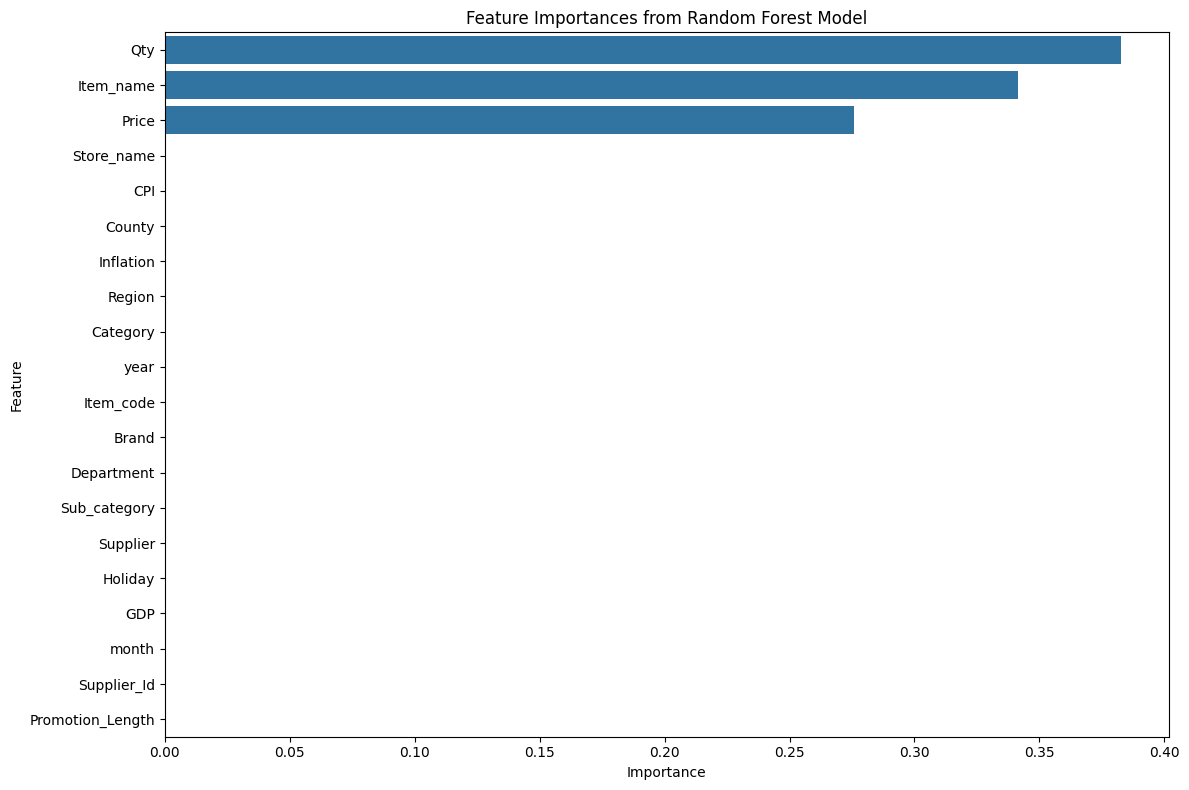

In [45]:
# Feature importance analysis
feature_importances = pd.DataFrame(
    {'feature': X_train_selected.columns, 'importance': best_model.feature_importances_}
)
feature_importances = feature_importances.sort_values('importance', ascending=False)
print("Top 10 features:")
print(feature_importances.head(10))

# Visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20)) # Display top 20 features
plt.title('Feature Importances from Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
import streamlit as st
import numpy as np
import pandas as pd
import joblib
import json

# 1) Load model and preprocessor
@st.cache(allow_output_mutation=True)
def load_model():
    model = joblib.load("model/model.pkl")  # adjust path/filename
    try:
        preprocessor = joblib.load("model/preprocessor.pkl")
    except Exception:
        preprocessor = None
    return model, preprocessor

model, preprocessor = load_model()

# 2) Load feature importances
with open("data/feature_importances.json", "r") as f:
    feature_importances = json.load(f)

# 3) UI
st.title("Predictive Model Demo")

st.write("""
This app demonstrates a deployed model with inputs for the top 10 features and a visualization of feature importances.
""")

st.sidebar.header("Input features")

# Create input widgets for the top features
def input_selector(name, value, vmin=None, vmax=None, options=None):
    if options is not None:
        return st.sidebar.selectbox(name, options, index=0)
    if isinstance(value, (int, float)):
        return st.sidebar.number_input(name, value=float(value), min_value=vmin, max_value=vmax)
    else:
        # Fallback to text input
        return st.sidebar.text_input(name, value=str(value))

# Defaults from feature_importances keys
inputs = {}
for feat in feature_importances.keys():
    # You can customize ranges per feature if you know valid ranges
    if feat in ["Qty", "Item_code", "Brand", "Supplier_Id", "Department", "Category"]:
        inputs[feat] = input_selector(feat, 0)
    else:
        inputs[feat] = input_selector(feat, "")

# 4) Prepare input for model
# Build a dataframe with the expected feature columns
# Ensure the order matches what the model expects; you may need to align with training columns.
feature_order = list(feature_importances.keys())
input_df = pd.DataFrame([ [inputs.get(f, 0) for f in feature_order] ], columns=feature_order)

# If you have a preprocessing step, apply it
if preprocessor is not None:
    X = preprocessor.transform(input_df)
else:
    X = input_df.values

# 5) Model prediction
if st.button("Predict"):
    pred = model.predict(X)
    # If model is probabilistic or returns multiple classes, adjust accordingly
    st.subheader("Prediction")
    st.write(pred[0])

# 6) Feature importances visualization
st.subheader("Top 10 Feature Importances")
fi_df = pd.DataFrame({
    "feature": list(feature_importances.keys()),
    "importance": [feature_importances[k] for k in feature_importances.keys()]
}).sort_values(by="importance", ascending=False)

st.bar_chart(fi_df.set_index("feature")["importance"])

# Optional: display a table
st.table(fi_df)